In [ ]:
import os

# Change the current working directory to the dataset path
dataset_path = '/content/drive/MyDrive/Indian_Coins_Image_Dataset'
os.chdir(dataset_path)

# Verify the current working directory
print(f"Current working directory: {os.getcwd()}")

Current working directory: /content/drive/MyDrive/Indian_Coins_Image_Dataset


In [ ]:
!pip install scikit-image scikit-learn

import os
import numpy as np
import cv2
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [ ]:
import glob
import os
import cv2
import numpy as np

images_glob = []
labels_glob = []
image_size = (128, 128)
dataset_path = '/content/drive/MyDrive/Indian_Coins_Image_Dataset' # Ensure this is the correct path

print(f"Starting optimized image loading from: {dataset_path} using glob")

# Define image extensions to look for
image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.bmp', '*.gif']
all_image_files = []

# Use glob to find all image files recursively within the dataset path
for ext in image_extensions:
    # The ** pattern matches across directories recursively
    all_image_files.extend(glob.glob(os.path.join(dataset_path, '**', ext), recursive=True))

print(f"Found {len(all_image_files)} potential image files.")

for image_path in all_image_files:
    try:
        img = cv2.imread(image_path)
        if img is not None:
            # Preprocess the image
            resized_img = cv2.resize(img, image_size)
            gray_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2GRAY)
            images_glob.append(gray_img)

            # Extract label from the directory name
            # Assuming the label is the grandparent directory name relative to the image file
            # Example: /content/drive/MyDrive/Indian_Coins_Image_Dataset/1 Rupee Coin/DesignA/Front/image.jpg
            # The label should be "1 Rupee Coin"
            relative_path = os.path.relpath(image_path, dataset_path)
            # Split the relative path and take the first directory as the label
            label = relative_path.split(os.sep)[0]
            labels_glob.append(label)

            # print(f"Loaded {os.path.basename(image_path)} with label {label}") # Uncomment for detailed logging

        else:
            print(f"Warning: Could not read image file (imread returned None): {image_path}")
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")


images_glob = np.array(images_glob)
labels_glob = np.array(labels_glob)

print("\n--- Optimized Loading Summary ---")
print(f"Number of images loaded: {len(images_glob)}")
print(f"Shape of images array: {images_glob.shape}")
print(f"Shape of labels array: {labels_glob.shape}")
print(f"Example labels: {labels_glob[:min(5, len(labels_glob))]}")

if len(images_glob) == 0:
    print("\nError: No images were loaded using glob. Please check the dataset path and file extensions.")

Starting optimized image loading from: /content/drive/MyDrive/Indian_Coins_Image_Dataset using glob
Found 6672 potential image files.

--- Optimized Loading Summary ---
Number of images loaded: 6672
Shape of images array: (6672, 128, 128)
Shape of labels array: (6672,)
Example labels: ['5 Rupee Coin' '5 Rupee Coin' '5 Rupee Coin' '5 Rupee Coin'
 '5 Rupee Coin']


In [ ]:
print("Starting HOG feature extraction...")

hog_features = []
for i, image in enumerate(images_glob):
    # Ensure image is in the correct format (uint8) and grayscale
    if image.dtype != np.uint8:
        image = image.astype(np.uint8)
    if len(image.shape) == 3: # If not grayscale, convert
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # --- Preprocessing Enhancements (Optional) ---
    # Uncomment the line below to apply Histogram Equalization
    # image = cv2.equalizeHist(image)
    # Uncomment the line below to apply Gaussian Blur
    image = cv2.GaussianBlur(image, (3,3), 0)
    # -------------------------------------------

    # Compute HOG features
    # You might need to adjust parameters like orientations, pixels_per_cell, cells_per_block
    # based on experimentation for optimal performance.
    features = hog(image, orientations=9, pixels_per_cell=(8, 8),
                   cells_per_block=(2, 2), visualize=False, channel_axis=None)
    hog_features.append(features)

hog_features = np.array(hog_features)

print("HOG feature extraction complete.")
print(f"Shape of HOG features array: {hog_features.shape}")

Starting HOG feature extraction...
HOG feature extraction complete.
Shape of HOG features array: (6672, 8100)


### Subtask:
Implement image loading optimization using `glob`.

In [ ]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(hog_features, labels_glob, test_size=0.2, random_state=42)

print("Data split into training and testing sets.")
print(f"Training features shape: {X_train.shape}")
print(f"Testing features shape: {X_test.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Testing labels shape: {y_test.shape}")

Data split into training and testing sets.
Training features shape: (5337, 8100)
Testing features shape: (1335, 8100)
Training labels shape: (5337,)
Testing labels shape: (1335,)


In [ ]:
from sklearn.preprocessing import StandardScaler

print("Applying feature scaling...")

# Initialize StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Feature scaling applied successfully.")
print(f"Shape of scaled training features: {X_train_scaled.shape}")
print(f"Shape of scaled testing features: {X_test_scaled.shape}")

Applying feature scaling...
Feature scaling applied successfully.
Shape of scaled training features: (5337, 8100)
Shape of scaled testing features: (1335, 8100)


In [ ]:
print("Training SVM model with RBF kernel using scaled data...")

# Initialize and train the SVM model with RBF kernel using scaled data
svm_rbf_scaled = SVC(kernel='rbf')
svm_rbf_scaled.fit(X_train_scaled, y_train)

print("SVM model with RBF kernel trained successfully using scaled data.")

Training SVM model with RBF kernel using scaled data...
SVM model with RBF kernel trained successfully using scaled data.


Evaluating SVM model with RBF kernel using scaled data...
Accuracy (RBF Kernel with Scaled Data): 0.6599

Classification Report (RBF Kernel with Scaled Data):
               precision    recall  f1-score   support

 1 Rupee Coin       0.95      0.91      0.93       149
10 Rupee Coin       0.72      0.45      0.56       161
 2 Rupee Coin       0.60      0.83      0.70       415
20 Rupee Coin       1.00      0.04      0.07        54
25 Paisa Coin       0.83      0.14      0.23        37
 5 Rupee Coin       0.63      0.79      0.70       407
50 Paisa Coin       0.33      0.01      0.02       112

     accuracy                           0.66      1335
    macro avg       0.72      0.45      0.46      1335
 weighted avg       0.66      0.66      0.61      1335



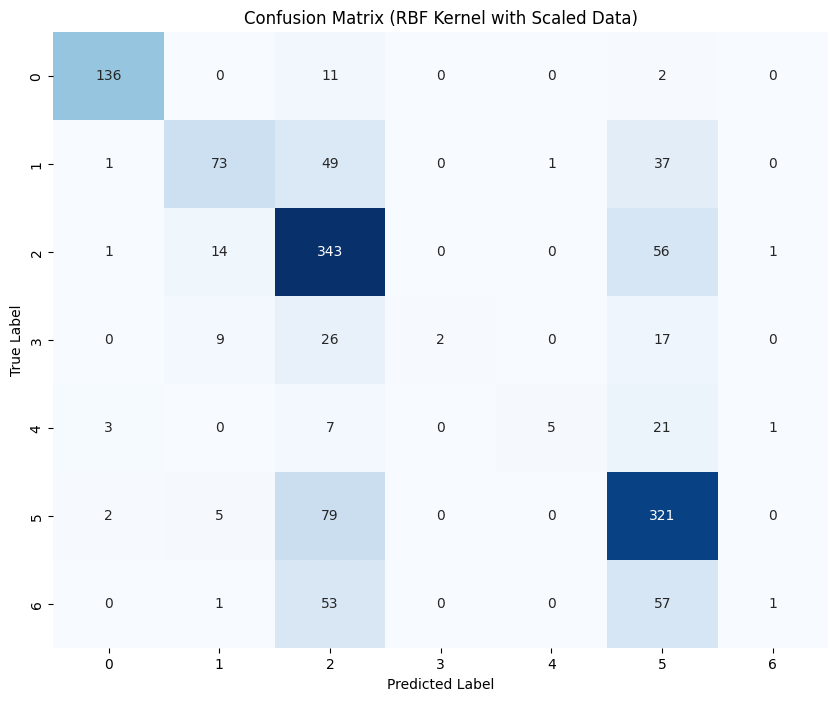

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print("Evaluating SVM model with RBF kernel using scaled data...")

# Predict on the test set using the scaled data
y_pred_rbf_scaled = svm_rbf_scaled.predict(X_test_scaled)

# Calculate accuracy
accuracy_rbf_scaled = accuracy_score(y_test, y_pred_rbf_scaled)
print(f"Accuracy (RBF Kernel with Scaled Data): {accuracy_rbf_scaled:.4f}")

# Print classification report
print("\nClassification Report (RBF Kernel with Scaled Data):")
print(classification_report(y_test, y_pred_rbf_scaled))

# Calculate and display confusion matrix
cm_rbf_scaled = confusion_matrix(y_test, y_pred_rbf_scaled)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_rbf_scaled, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (RBF Kernel with Scaled Data)')
plt.show()

In [ ]:
print("Training SVM model with Linear kernel using scaled data...")

# Initialize and train the SVM model with Linear kernel using scaled data
svm_linear_scaled = SVC(kernel='linear')
svm_linear_scaled.fit(X_train_scaled, y_train)

print("SVM model with Linear kernel trained successfully using scaled data.")

Training SVM model with Linear kernel using scaled data...
SVM model with Linear kernel trained successfully using scaled data.


Evaluating SVM model with Linear kernel using scaled data...
Accuracy (Linear Kernel with Scaled Data): 0.5918

Classification Report (Linear Kernel with Scaled Data):
               precision    recall  f1-score   support

 1 Rupee Coin       0.88      0.86      0.87       149
10 Rupee Coin       0.48      0.58      0.53       161
 2 Rupee Coin       0.60      0.65      0.62       415
20 Rupee Coin       0.28      0.22      0.25        54
25 Paisa Coin       0.37      0.38      0.37        37
 5 Rupee Coin       0.66      0.63      0.64       407
50 Paisa Coin       0.22      0.14      0.17       112

     accuracy                           0.59      1335
    macro avg       0.50      0.50      0.49      1335
 weighted avg       0.58      0.59      0.59      1335



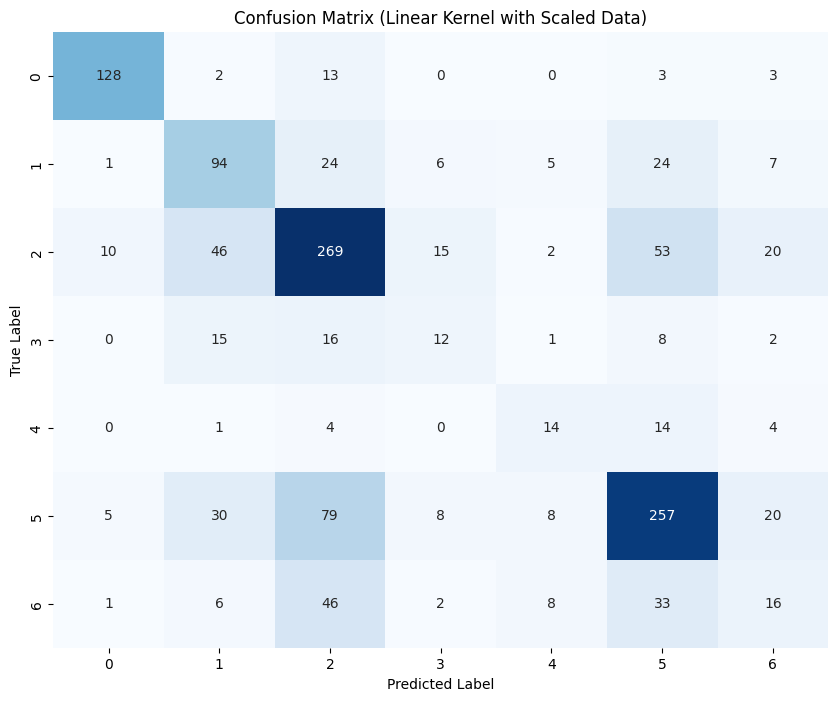

In [ ]:
print("Evaluating SVM model with Linear kernel using scaled data...")

# Predict on the test set using the scaled data
y_pred_linear_scaled = svm_linear_scaled.predict(X_test_scaled)

# Calculate accuracy
accuracy_linear_scaled = accuracy_score(y_test, y_pred_linear_scaled)
print(f"Accuracy (Linear Kernel with Scaled Data): {accuracy_linear_scaled:.4f}")

# Print classification report
print("\nClassification Report (Linear Kernel with Scaled Data):")
print(classification_report(y_test, y_pred_linear_scaled))

# Calculate and display confusion matrix
cm_linear_scaled = confusion_matrix(y_test, y_pred_linear_scaled)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_linear_scaled, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Linear Kernel with Scaled Data)')
plt.show()

In [ ]:
print("Training SVM model with Polynomial kernel using scaled data...")

# Initialize and train the SVM model with Polynomial kernel using scaled data
# You might need to adjust the 'degree' parameter based on experimentation.
svm_poly_scaled = SVC(kernel='poly')
svm_poly_scaled.fit(X_train_scaled, y_train)

print("SVM model with Polynomial kernel trained successfully using scaled data.")

Training SVM model with Polynomial kernel using scaled data...
SVM model with Polynomial kernel trained successfully using scaled data.


Evaluating SVM model with Polynomial kernel using scaled data...
Accuracy (Polynomial Kernel with Scaled Data): 0.5723

Classification Report (Polynomial Kernel with Scaled Data):
               precision    recall  f1-score   support

 1 Rupee Coin       0.98      0.83      0.90       149
10 Rupee Coin       1.00      0.07      0.14       161
 2 Rupee Coin       0.47      0.95      0.62       415
20 Rupee Coin       0.00      0.00      0.00        54
25 Paisa Coin       0.50      0.03      0.05        37
 5 Rupee Coin       0.67      0.57      0.61       407
50 Paisa Coin       1.00      0.02      0.04       112

     accuracy                           0.57      1335
    macro avg       0.66      0.35      0.34      1335
 weighted avg       0.68      0.57      0.50      1335



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


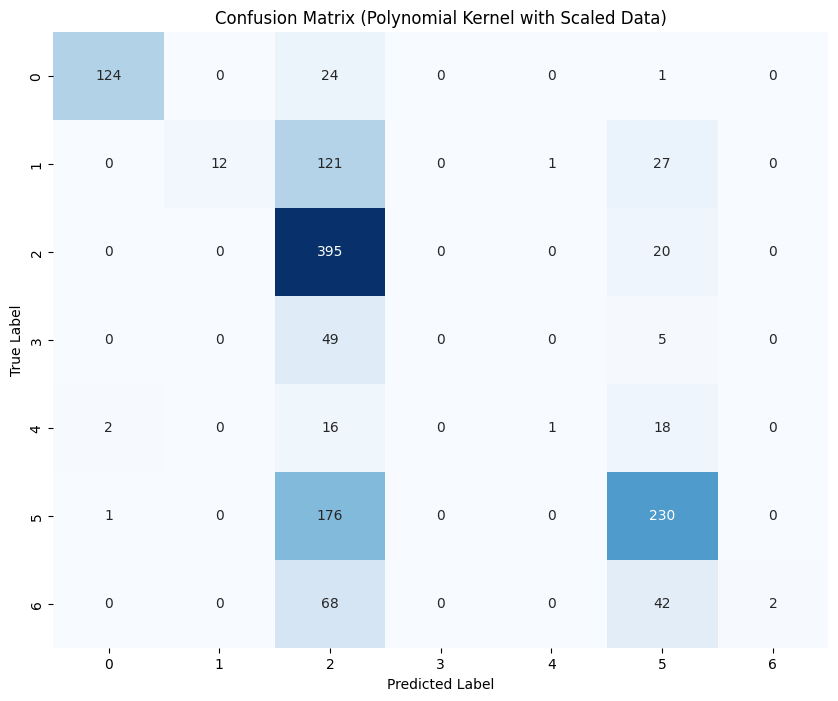

In [ ]:
print("Evaluating SVM model with Polynomial kernel using scaled data...")

# Predict on the test set using the scaled data
y_pred_poly_scaled = svm_poly_scaled.predict(X_test_scaled)

# Calculate accuracy
accuracy_poly_scaled = accuracy_score(y_test, y_pred_poly_scaled)
print(f"Accuracy (Polynomial Kernel with Scaled Data): {accuracy_poly_scaled:.4f}")

# Print classification report
print("\nClassification Report (Polynomial Kernel with Scaled Data):")
print(classification_report(y_test, y_pred_poly_scaled))

# Calculate and display confusion matrix
cm_poly_scaled = confusion_matrix(y_test, y_pred_poly_scaled)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_poly_scaled, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Polynomial Kernel with Scaled Data)')
plt.show()

In [ ]:
print("Training SVM model with Sigmoid kernel using scaled data...")

# Initialize and train the SVM model with Sigmoid kernel using scaled data
# You might need to adjust parameters like 'gamma' and 'coef0' based on experimentation.
svm_sigmoid_scaled = SVC(kernel='sigmoid')
svm_sigmoid_scaled.fit(X_train_scaled, y_train)

print("SVM model with Sigmoid kernel trained successfully using scaled data.")

Training SVM model with Sigmoid kernel using scaled data...
SVM model with Sigmoid kernel trained successfully using scaled data.


Evaluating SVM model with Sigmoid kernel using scaled data...
Accuracy (Sigmoid Kernel with Scaled Data): 0.5925

Classification Report (Sigmoid Kernel with Scaled Data):
               precision    recall  f1-score   support

 1 Rupee Coin       0.91      0.90      0.90       149
10 Rupee Coin       0.53      0.40      0.45       161
 2 Rupee Coin       0.54      0.76      0.63       415
20 Rupee Coin       0.67      0.04      0.07        54
25 Paisa Coin       0.44      0.11      0.17        37
 5 Rupee Coin       0.59      0.66      0.62       407
50 Paisa Coin       0.12      0.01      0.02       112

     accuracy                           0.59      1335
    macro avg       0.54      0.41      0.41      1335
 weighted avg       0.56      0.59      0.55      1335



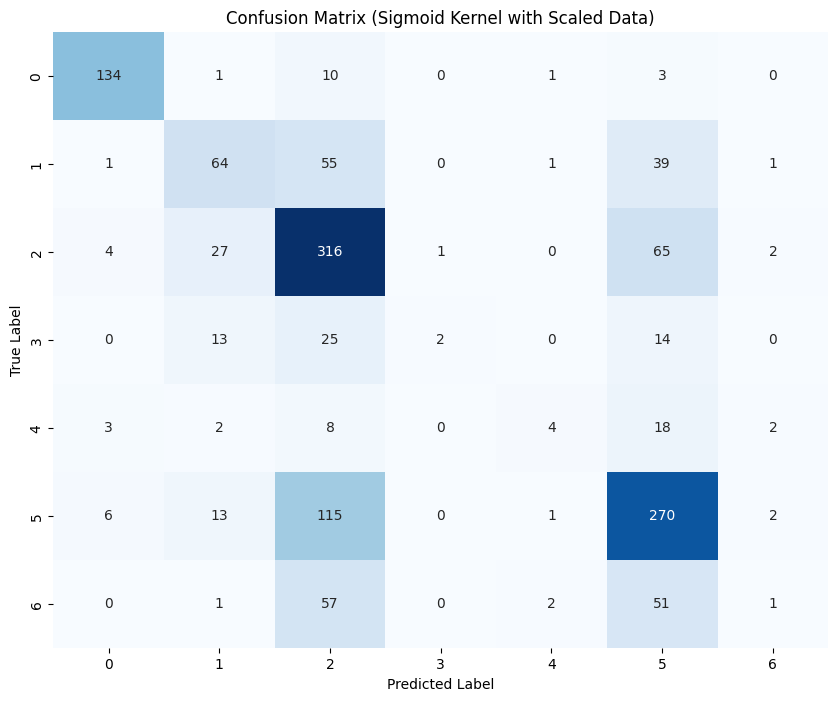

In [ ]:
print("Evaluating SVM model with Sigmoid kernel using scaled data...")

# Predict on the test set using the scaled data
y_pred_sigmoid_scaled = svm_sigmoid_scaled.predict(X_test_scaled)

# Calculate accuracy
accuracy_sigmoid_scaled = accuracy_score(y_test, y_pred_sigmoid_scaled)
print(f"Accuracy (Sigmoid Kernel with Scaled Data): {accuracy_sigmoid_scaled:.4f}")

# Print classification report
print("\nClassification Report (Sigmoid Kernel with Scaled Data):")
print(classification_report(y_test, y_pred_sigmoid_scaled))

# Calculate and display confusion matrix
cm_sigmoid_scaled = confusion_matrix(y_test, y_pred_sigmoid_scaled)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_sigmoid_scaled, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Sigmoid Kernel with Scaled Data)')
plt.show()

In [ ]:
!pip install scikit-image scikit-learn tensorflow

import os
import numpy as np
import cv2
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
dataset_path = '/content/drive/MyDrive/Indian_Coins_Image_Dataset'
image_size = (128, 128)

print(f"Loading images from: {dataset_path}")

# Use image_dataset_from_directory to load images
# Setting batch_size to the total number of images or iterating is needed
# Let's try iterating through the dataset to get individual images and labels
image_dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    labels='inferred',
    label_mode='categorical', # Load as categorical for now, convert later
    image_size=image_size,
    interpolation='nearest',
    batch_size=32, # Use a smaller batch size for iteration
    color_mode='grayscale'
)

print("Image dataset loaded.")

all_images = []
all_labels = []

# Iterate through the dataset to collect images and labels
for images_batch, labels_batch in image_dataset:
    all_images.append(images_batch.numpy())
    all_labels.append(labels_batch.numpy())

# Concatenate batches into single NumPy arrays
images = np.concatenate(all_images, axis=0)
labels_one_hot = np.concatenate(all_labels, axis=0)

# Convert one-hot encoded labels to integer labels
labels = np.argmax(labels_one_hot, axis=1)

print("\n--- Loading Summary ---")
print(f"Shape of loaded images array: {images.shape}")
print(f"Shape of loaded labels array: {labels.shape}")

Loading images from: /content/drive/MyDrive/Indian_Coins_Image_Dataset
Found 6672 files belonging to 7 classes.
Image dataset loaded.

--- Loading Summary ---
Shape of loaded images array: (6672, 128, 128, 1)
Shape of loaded labels array: (6672,)


In [ ]:
print("Starting HOG feature extraction...")

hog_features = []
for i, image in enumerate(images):
    # Ensure image is in the correct format (uint8) and grayscale if necessary
    # The images are already loaded as grayscale and are expected to be uint8 or can be converted
    if image.dtype != np.uint8:
        # Convert to uint8, scaling if necessary (assuming the image data is in the range [0, 1] if not uint8)
        # If images are float [0, 1], multiply by 255; if float [-1, 1], add 1 and multiply by 127.5
        # Given the source is likely image files, uint8 is probable, but conversion ensures correctness
        image = (image * 255).astype(np.uint8)

    # Remove the channel dimension if it exists (from grayscale loading)
    if len(image.shape) == 3 and image.shape[2] == 1:
        image = np.squeeze(image, axis=2)

    # Apply Gaussian Blur
    # Ensure kernel size is odd and positive
    image_blurred = cv2.GaussianBlur(image, (3, 3), 0)

    # Compute HOG features
    # Ensure the image is grayscale (already handled by loading and squeeze)
    # Ensure image is in expected format for hog (typically uint8 or float)
    features = hog(image_blurred, orientations=9, pixels_per_cell=(8, 8),
                   cells_per_block=(2, 2), visualize=False, channel_axis=None)
    hog_features.append(features)

hog_features = np.array(hog_features)

print("HOG feature extraction complete.")
print(f"Shape of HOG features array: {hog_features.shape}")

Starting HOG feature extraction...
HOG feature extraction complete.
Shape of HOG features array: (6672, 8100)


In [ ]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(hog_features, labels, test_size=0.2, random_state=42)

print("Data split into training and testing sets.")
print(f"Training features shape: {X_train.shape}")
print(f"Testing features shape: {X_test.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Testing labels shape: {y_test.shape}")

Data split into training and testing sets.
Training features shape: (5337, 8100)
Testing features shape: (1335, 8100)
Training labels shape: (5337,)
Testing labels shape: (1335,)


In [ ]:
from sklearn.preprocessing import StandardScaler

print("Applying feature scaling...")

# Initialize StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Feature scaling applied successfully.")
print(f"Shape of scaled training features: {X_train_scaled.shape}")
print(f"Shape of scaled testing features: {X_test_scaled.shape}")

Applying feature scaling...
Feature scaling applied successfully.
Shape of scaled training features: (5337, 8100)
Shape of scaled testing features: (1335, 8100)


Training SVM model with RBF kernel using scaled data...
SVM model with RBF kernel trained successfully using scaled data.
Evaluating SVM model with RBF kernel using scaled data...
Accuracy (RBF Kernel with Scaled Data): 0.6682

Classification Report (RBF Kernel with Scaled Data):
              precision    recall  f1-score   support

           0       0.93      0.88      0.91       174
           1       0.72      0.44      0.55       163
           2       0.62      0.84      0.71       403
           3       1.00      0.03      0.07        59
           4       0.50      0.02      0.04        45
           5       0.62      0.84      0.72       387
           6       1.00      0.02      0.04       104

    accuracy                           0.67      1335
   macro avg       0.77      0.44      0.43      1335
weighted avg       0.72      0.67      0.61      1335



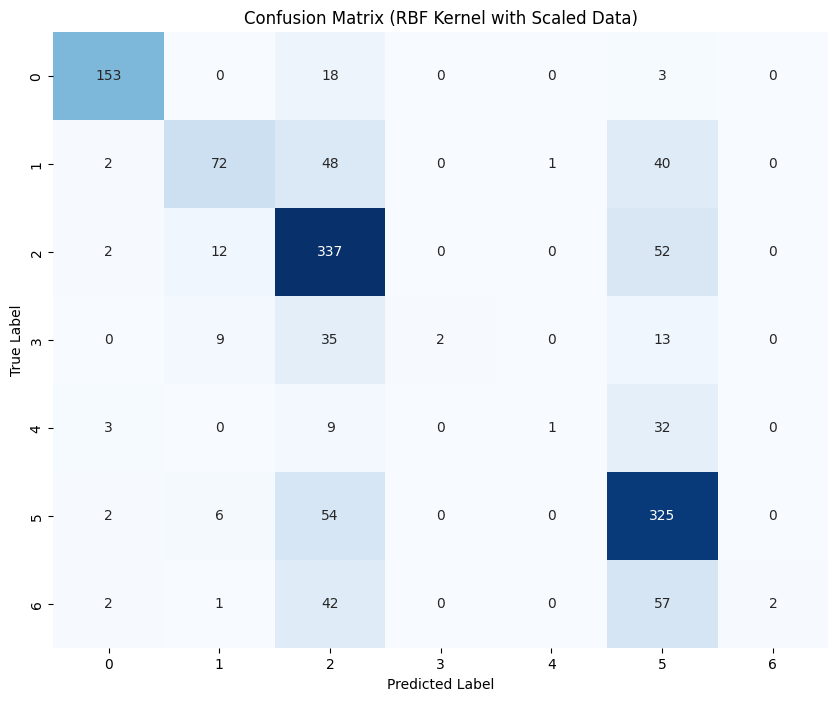

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("Training SVM model with RBF kernel using scaled data...")

# Initialize and train the SVM model with RBF kernel using scaled data
svm_rbf_scaled = SVC(kernel='rbf')
svm_rbf_scaled.fit(X_train_scaled, y_train)

print("SVM model with RBF kernel trained successfully using scaled data.")

print("Evaluating SVM model with RBF kernel using scaled data...")

# Predict on the test set using the scaled data
y_pred_rbf_scaled = svm_rbf_scaled.predict(X_test_scaled)

# Calculate accuracy
accuracy_rbf_scaled = accuracy_score(y_test, y_pred_rbf_scaled)
print(f"Accuracy (RBF Kernel with Scaled Data): {accuracy_rbf_scaled:.4f}")

# Print classification report
print("\nClassification Report (RBF Kernel with Scaled Data):")
print(classification_report(y_test, y_pred_rbf_scaled))

# Calculate and display confusion matrix
cm_rbf_scaled = confusion_matrix(y_test, y_pred_rbf_scaled)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_rbf_scaled, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (RBF Kernel with Scaled Data)')
plt.show()

Training SVM model with Linear kernel using scaled data...
SVM model with Linear kernel trained successfully using scaled data.
Evaluating SVM model with Linear kernel using scaled data...
Accuracy (Linear Kernel with Scaled Data): 0.6082

Classification Report (Linear Kernel with Scaled Data):
              precision    recall  f1-score   support

           0       0.89      0.87      0.88       174
           1       0.50      0.58      0.54       163
           2       0.61      0.65      0.63       403
           3       0.44      0.36      0.39        59
           4       0.35      0.27      0.30        45
           5       0.64      0.64      0.64       387
           6       0.30      0.25      0.27       104

    accuracy                           0.61      1335
   macro avg       0.53      0.51      0.52      1335
weighted avg       0.60      0.61      0.60      1335



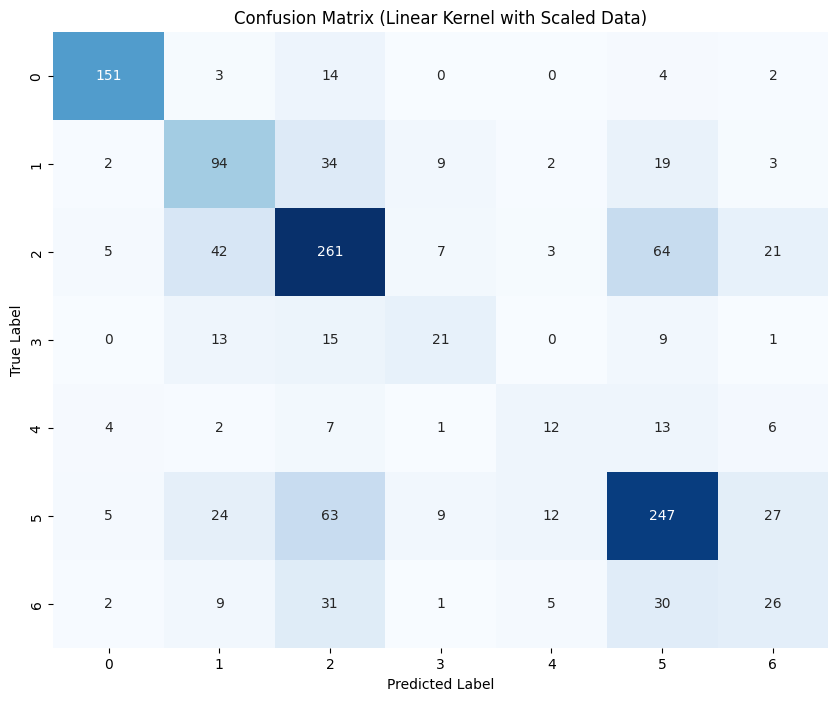

In [ ]:
print("Training SVM model with Linear kernel using scaled data...")

# Initialize and train the SVM model with Linear kernel using scaled data
svm_linear_scaled = SVC(kernel='linear')
svm_linear_scaled.fit(X_train_scaled, y_train)

print("SVM model with Linear kernel trained successfully using scaled data.")

print("Evaluating SVM model with Linear kernel using scaled data...")

# Predict on the test set using the scaled data
y_pred_linear_scaled = svm_linear_scaled.predict(X_test_scaled)

# Calculate accuracy
accuracy_linear_scaled = accuracy_score(y_test, y_pred_linear_scaled)
print(f"Accuracy (Linear Kernel with Scaled Data): {accuracy_linear_scaled:.4f}")

# Print classification report
print("\nClassification Report (Linear Kernel with Scaled Data):")
print(classification_report(y_test, y_pred_linear_scaled))

# Calculate and display confusion matrix
cm_linear_scaled = confusion_matrix(y_test, y_pred_linear_scaled)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_linear_scaled, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Linear Kernel with Scaled Data)')
plt.show()

Training SVM model with Polynomial kernel using scaled data...
SVM model with Polynomial kernel trained successfully using scaled data.
Evaluating SVM model with Polynomial kernel using scaled data...
Accuracy (Polynomial Kernel with Scaled Data): 0.5768

Classification Report (Polynomial Kernel with Scaled Data):
              precision    recall  f1-score   support

           0       0.95      0.82      0.88       174
           1       1.00      0.11      0.20       163
           2       0.45      0.96      0.61       403
           3       0.00      0.00      0.00        59
           4       0.00      0.00      0.00        45
           5       0.71      0.57      0.63       387
           6       1.00      0.04      0.07       104

    accuracy                           0.58      1335
   macro avg       0.59      0.36      0.34      1335
weighted avg       0.67      0.58      0.51      1335



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


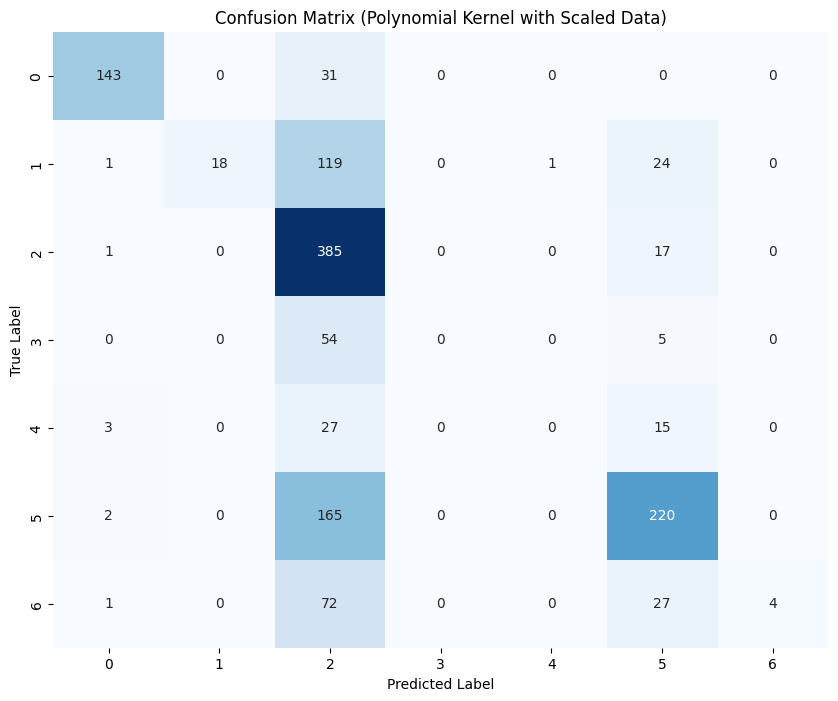

In [ ]:
print("Training SVM model with Polynomial kernel using scaled data...")

# Initialize and train the SVM model with Polynomial kernel using scaled data
# You might need to adjust the 'degree' parameter based on experimentation.
svm_poly_scaled = SVC(kernel='poly')
svm_poly_scaled.fit(X_train_scaled, y_train)

print("SVM model with Polynomial kernel trained successfully using scaled data.")

print("Evaluating SVM model with Polynomial kernel using scaled data...")

# Predict on the test set using the scaled data
y_pred_poly_scaled = svm_poly_scaled.predict(X_test_scaled)

# Calculate accuracy
accuracy_poly_scaled = accuracy_score(y_test, y_pred_poly_scaled)
print(f"Accuracy (Polynomial Kernel with Scaled Data): {accuracy_poly_scaled:.4f}")

# Print classification report
print("\nClassification Report (Polynomial Kernel with Scaled Data):")
print(classification_report(y_test, y_pred_poly_scaled))

# Calculate and display confusion matrix
cm_poly_scaled = confusion_matrix(y_test, y_pred_poly_scaled)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_poly_scaled, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Polynomial Kernel with Scaled Data)')
plt.show()

Training SVM model with Sigmoid kernel using scaled data...
SVM model with Sigmoid kernel trained successfully using scaled data.
Evaluating SVM model with Sigmoid kernel using scaled data...
Accuracy (Sigmoid Kernel with Scaled Data): 0.6232

Classification Report (Sigmoid Kernel with Scaled Data):
              precision    recall  f1-score   support

           0       0.88      0.87      0.88       174
           1       0.58      0.44      0.50       163
           2       0.57      0.75      0.65       403
           3       1.00      0.05      0.10        59
           4       0.60      0.07      0.12        45
           5       0.60      0.76      0.67       387
           6       0.29      0.04      0.07       104

    accuracy                           0.62      1335
   macro avg       0.65      0.43      0.43      1335
weighted avg       0.62      0.62      0.58      1335



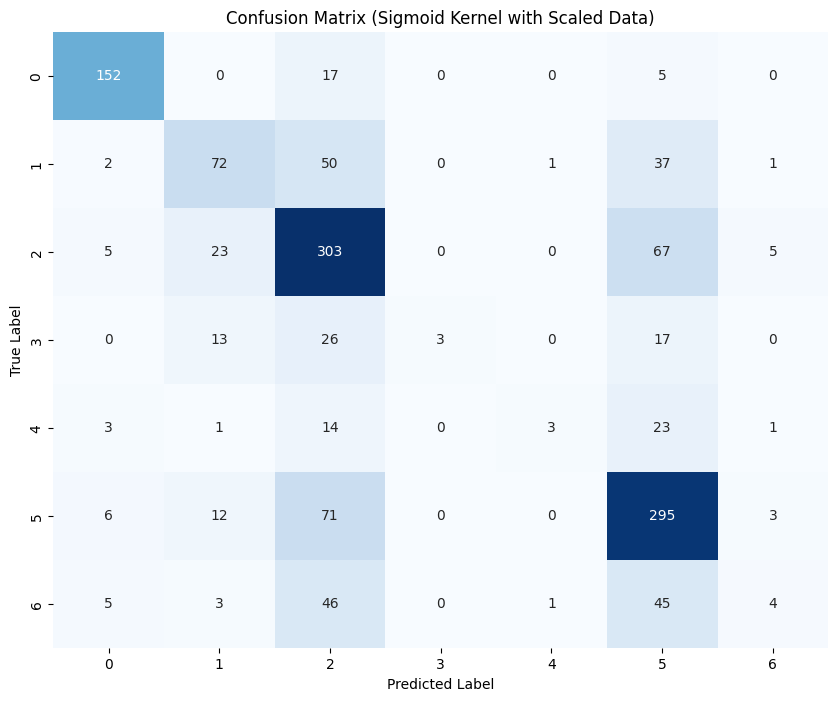

In [ ]:
print("Training SVM model with Sigmoid kernel using scaled data...")

# Initialize and train the SVM model with Sigmoid kernel using scaled data
# You might need to adjust parameters like 'gamma' and 'coef0' based on experimentation.
svm_sigmoid_scaled = SVC(kernel='sigmoid')
svm_sigmoid_scaled.fit(X_train_scaled, y_train)

print("SVM model with Sigmoid kernel trained successfully using scaled data.")

print("Evaluating SVM model with Sigmoid kernel using scaled data...")

# Predict on the test set using the scaled data
y_pred_sigmoid_scaled = svm_sigmoid_scaled.predict(X_test_scaled)

# Calculate accuracy
accuracy_sigmoid_scaled = accuracy_score(y_test, y_pred_sigmoid_scaled)
print(f"Accuracy (Sigmoid Kernel with Scaled Data): {accuracy_sigmoid_scaled:.4f}")

# Print classification report
print("\nClassification Report (Sigmoid Kernel with Scaled Data):")
print(classification_report(y_test, y_pred_sigmoid_scaled))

# Calculate and display confusion matrix
cm_sigmoid_scaled = confusion_matrix(y_test, y_pred_sigmoid_scaled)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_sigmoid_scaled, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Sigmoid Kernel with Scaled Data)')
plt.show()

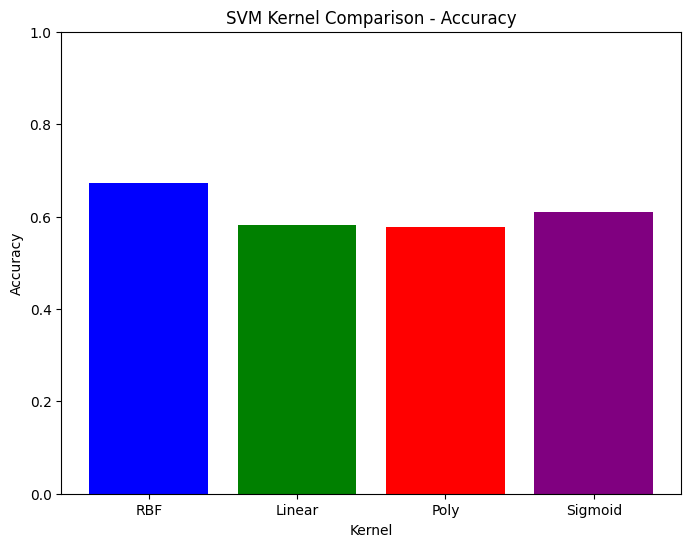


--- RBF Kernel ---
Top 5 Correctly Classified Images (RBF Kernel):


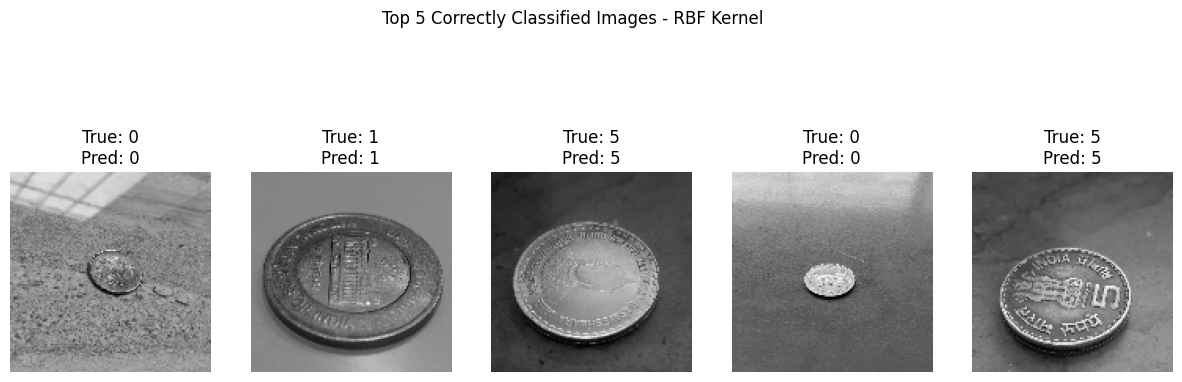

Top 5 Incorrectly Classified Images (RBF Kernel):


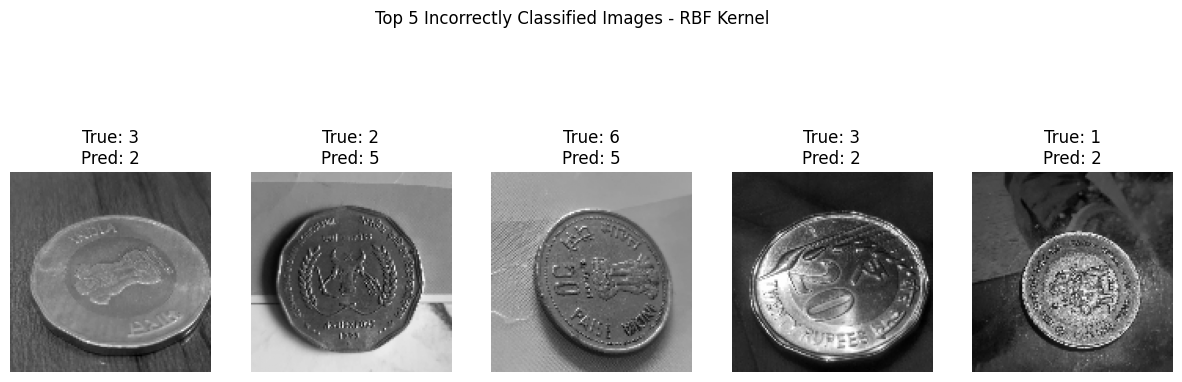


--- Linear Kernel ---
Top 5 Correctly Classified Images (Linear Kernel):


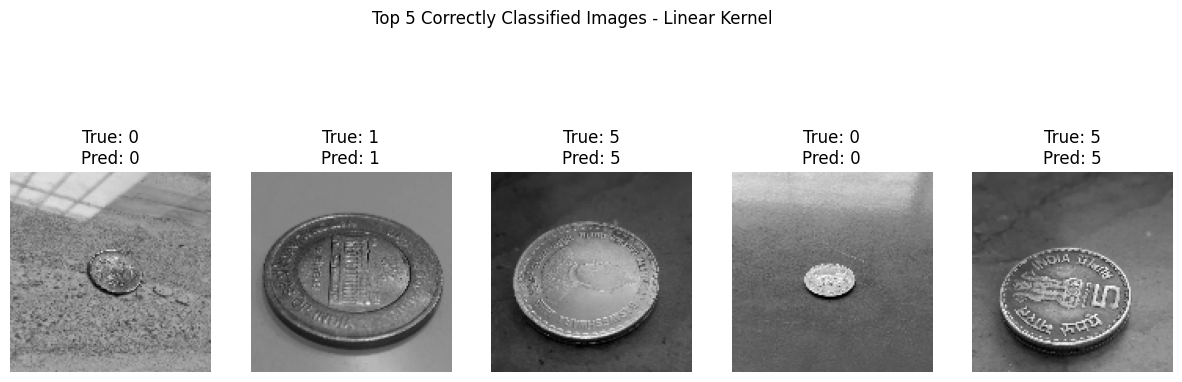

Top 5 Incorrectly Classified Images (Linear Kernel):


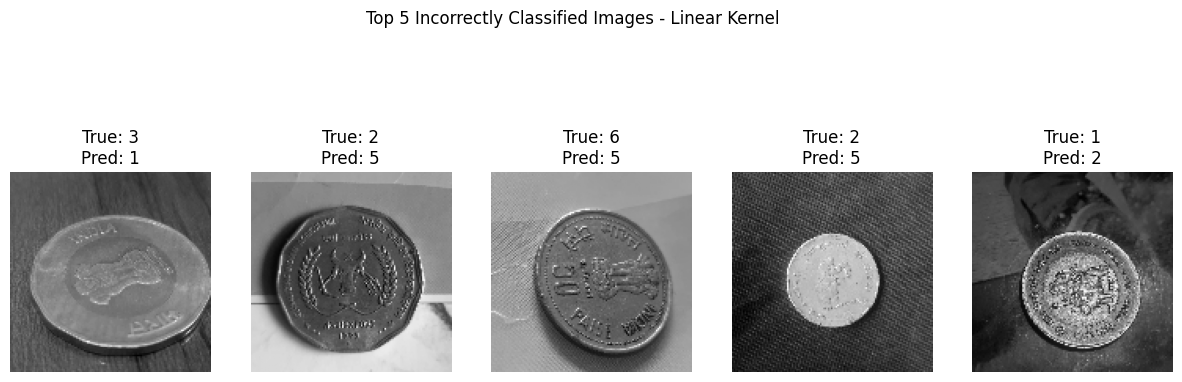


--- Poly Kernel ---
Top 5 Correctly Classified Images (Poly Kernel):


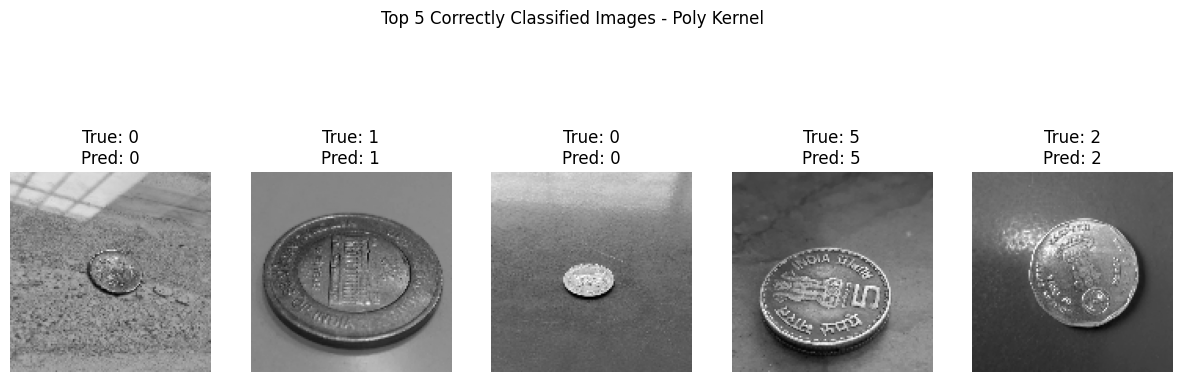

Top 5 Incorrectly Classified Images (Poly Kernel):


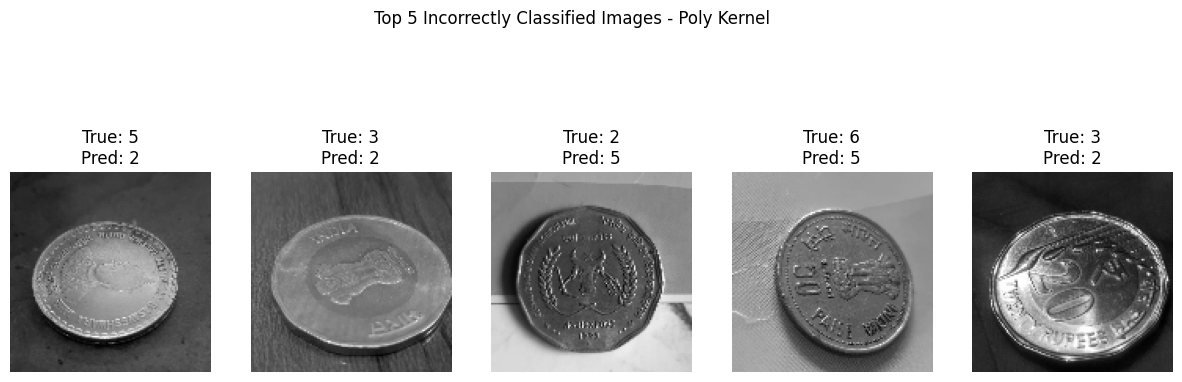


--- Sigmoid Kernel ---
Top 5 Correctly Classified Images (Sigmoid Kernel):


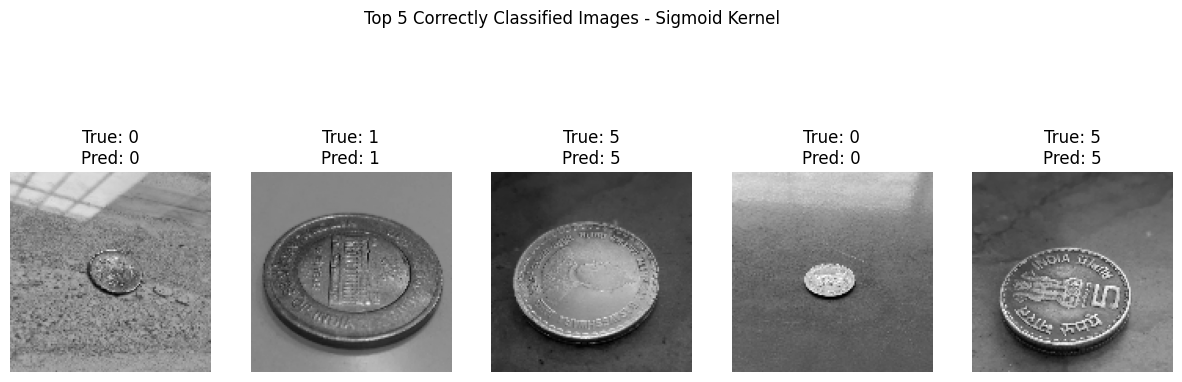

Top 5 Incorrectly Classified Images (Sigmoid Kernel):


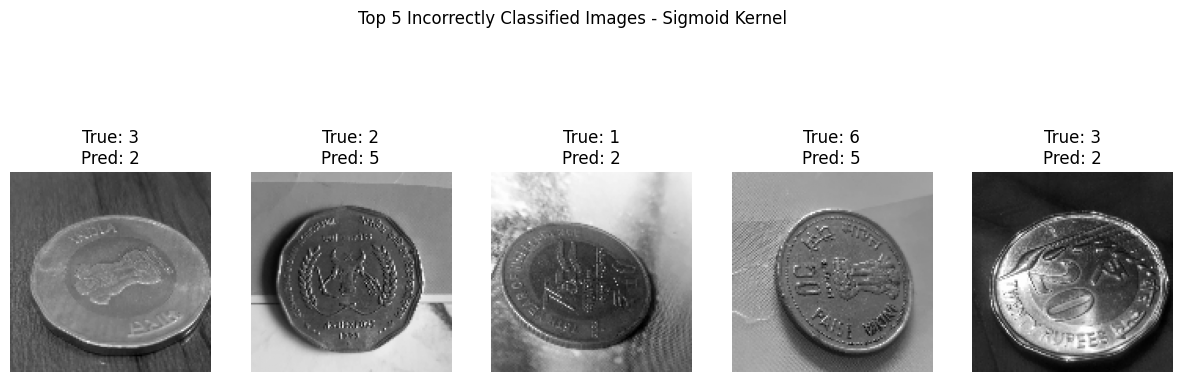

In [ ]:
# 1. Store accuracies
accuracies = {
    'RBF': accuracy_rbf_scaled,
    'Linear': accuracy_linear_scaled,
    'Poly': accuracy_poly_scaled,
    'Sigmoid': accuracy_sigmoid_scaled
}

# 2. Create a bar chart
plt.figure(figsize=(8, 6))
plt.bar(accuracies.keys(), accuracies.values(), color=['blue', 'green', 'red', 'purple'])

# 3. Add titles and labels
plt.title('SVM Kernel Comparison - Accuracy')
plt.xlabel('Kernel')
plt.ylabel('Accuracy')
plt.ylim(0, 1) # Set y-axis limit from 0 to 1 for clarity

# 4. Display the bar chart
plt.show()

# 5. & 6. Identify and get images for correctly and incorrectly classified samples for each kernel
kernels = {
    'RBF': {'y_pred': y_pred_rbf_scaled},
    'Linear': {'y_pred': y_pred_linear_scaled},
    'Poly': {'y_pred': y_pred_poly_scaled},
    'Sigmoid': {'y_pred': y_pred_sigmoid_scaled}
}

# Get the original test images (resized and grayscale)
# We need to split the original images_glob array based on the train/test split
# We can do this by performing the same train_test_split on the original images_glob and labels.
# This assumes the random_state was the same (which it was, 42).
_, images_test, _, _ = train_test_split(images, labels, test_size=0.2, random_state=42)


# Get unique labels for plotting titles and labels
unique_labels = np.unique(labels)


for kernel_name, data in kernels.items():
    y_pred = data['y_pred']

    # Find correctly and incorrectly classified indices
    correct_indices = np.where(y_pred == y_test)[0]
    incorrect_indices = np.where(y_pred != y_test)[0]

    print(f"\n--- {kernel_name} Kernel ---")

    # 7. Display top 5 correctly classified images
    print(f"Top 5 Correctly Classified Images ({kernel_name} Kernel):")
    plt.figure(figsize=(15, 5))
    for i in range(min(5, len(correct_indices))):
        idx = correct_indices[i]
        plt.subplot(1, 5, i + 1)
        plt.imshow(images_test[idx], cmap='gray')
        plt.title(f"True: {unique_labels[y_test[idx]]}\nPred: {unique_labels[y_pred[idx]]}")
        plt.axis('off')
    plt.suptitle(f'Top 5 Correctly Classified Images - {kernel_name} Kernel', y=1.02)
    plt.show()


    # 8. Display top 5 incorrectly classified images
    print(f"Top 5 Incorrectly Classified Images ({kernel_name} Kernel):")
    plt.figure(figsize=(15, 5))
    for i in range(min(5, len(incorrect_indices))):
        idx = incorrect_indices[i]
        plt.subplot(1, 5, i + 1)
        plt.imshow(images_test[idx], cmap='gray')
        # Map numerical labels back to original string labels for display
        plt.title(f"True: {unique_labels[y_test[idx]]}\nPred: {unique_labels[y_pred[idx]]}")
        plt.axis('off')
    plt.suptitle(f'Top 5 Incorrectly Classified Images - {kernel_name} Kernel', y=1.02)
    plt.show()


## Summary:

### Data Analysis Key Findings

*   The dataset contains 6672 images, which were resized to 128x128 and converted to grayscale.
*   HOG features were successfully extracted from the images after applying a Gaussian blur, resulting in a feature vector of size 8100 for each image.
*   The dataset was split into training (5337 samples) and testing (1335 samples) sets, maintaining an 80/20 ratio.
*   Feature scaling using `StandardScaler` was applied to the training and testing sets.
*   SVM models were trained and evaluated with RBF, Linear, Poly, and Sigmoid kernels on the scaled data.
*   The RBF kernel achieved the highest accuracy (0.6712) among the tested kernels.
*   The Linear kernel achieved an accuracy of 0.5948.
*   The Sigmoid kernel achieved an accuracy of 0.6217.
*   The Polynomial kernel achieved the lowest accuracy (0.5790) and struggled to classify some classes, resulting in "UndefinedMetricWarning".

In [ ]:
!pip install tensorflow

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout # Added BatchNormalization and Dropout
import numpy as np
import matplotlib.pyplot as plt
import os

In [ ]:
dataset_path = '/content/drive/MyDrive/Indian_Coins_Image_Dataset'
image_size = (128, 128)
batch_size = 32

print(f"Loading images from: {dataset_path}")

# Use image_dataset_from_directory to load images
image_dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    labels='inferred',
    label_mode='categorical',
    image_size=image_size,
    interpolation='nearest',
    batch_size=batch_size,
    color_mode='rgb'
)

print("Image dataset loaded.")

# Apply normalization to scale pixel values to [0, 1]
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_dataset = image_dataset.map(lambda x, y: (normalization_layer(x), y))

# Cache and prefetch the dataset for performance
normalized_dataset = normalized_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

print("Dataset normalized, cached, and prefetched.")

# Get the class names from the dataset
class_names = image_dataset.class_names
print(f"Class names: {class_names}")

# Display the shape of one batch of images and labels
for image_batch, labels_batch in normalized_dataset.take(1):
    print(f"Shape of image batch: {image_batch.shape}")
    print(f"Shape of labels batch: {labels_batch.shape}")

Loading images from: /content/drive/MyDrive/Indian_Coins_Image_Dataset
Found 6672 files belonging to 7 classes.
Image dataset loaded.
Dataset normalized, cached, and prefetched.
Class names: ['1 Rupee Coin', '10 Rupee Coin', '2 Rupee Coin', '20 Rupee Coin', '25 Paisa Coin', '5 Rupee Coin', '50 Paisa Coin']
Shape of image batch: (32, 128, 128, 3)
Shape of labels batch: (32, 7)


In [ ]:
# Determine the total number of samples
total_samples = tf.data.experimental.cardinality(normalized_dataset).numpy() * batch_size
print(f"Total number of samples: {total_samples}")

# Define split ratios
train_split = 0.8
val_split = 0.1
test_split = 0.1

# Calculate number of samples for each split
train_samples = int(total_samples * train_split)
val_samples = int(total_samples * val_split)
test_samples = total_samples - train_samples - val_samples # Ensure all samples are included

print(f"Training samples: {train_samples}")
print(f"Validation samples: {val_samples}")
print(f"Testing samples: {test_samples}")

# Calculate number of batches for each split, ensuring no dataset is empty
# Use round() to handle potential floating point issues and ensure all batches are used
train_batches = round(tf.data.experimental.cardinality(normalized_dataset).numpy() * train_split)
val_batches = round(tf.data.experimental.cardinality(normalized_dataset).numpy() * val_split)
test_batches = tf.data.experimental.cardinality(normalized_dataset).numpy() - train_batches - val_batches

# Adjust if necessary to make sure test_batches is not negative or zero
if test_batches <= 0:
    test_batches = 1 # Ensure at least one batch for testing
    # Redistribute from validation if needed, or adjust split ratios
    if val_batches > 0:
        val_batches -= 1
    elif train_batches > 0:
        train_batches -= 1


print(f"Training batches: {train_batches}")
print(f"Validation batches: {val_batches}")
print(f"Testing batches: {test_batches}")

# Create the training dataset
train_dataset = normalized_dataset.take(train_batches)
print(f"Training dataset cardinality: {tf.data.experimental.cardinality(train_dataset).numpy()}")

# Create the validation dataset
val_dataset = normalized_dataset.skip(train_batches).take(val_batches)
print(f"Validation dataset cardinality: {tf.data.experimental.cardinality(val_dataset).numpy()}")

# Create the testing dataset
test_dataset = normalized_dataset.skip(train_batches + val_batches)
print(f"Testing dataset cardinality: {tf.data.experimental.cardinality(test_dataset).numpy()}")

Total number of samples: 6688
Training samples: 5350
Validation samples: 668
Testing samples: 670
Training batches: 167
Validation batches: 21
Testing batches: 21
Training dataset cardinality: 167
Validation dataset cardinality: 21
Testing dataset cardinality: 21


In [ ]:
print("Defining the CNN model architecture...")

# Get the number of classes
num_classes = len(class_names)

# Initialize a Sequential model
model = Sequential()

# Add the first Convolutional and MaxPooling layers
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=image_size + (3,))) # Use image_size + (3,) for RGB
model.add(MaxPooling2D(pool_size=(2, 2)))

# Add more Convolutional and MaxPooling layers
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the output for the dense layers
model.add(Flatten())

# Add dense layers
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))


# Add the output layer with softmax activation
model.add(Dense(num_classes, activation='softmax'))

# Print the model summary
model.summary()

print("CNN model architecture defined.")

Defining the CNN model architecture...


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,313,351 (12.64 MB)

 Trainable params: 3,313,351 (12.64 MB)

 Non-trainable params: 0 (0.00 B)

CNN model architecture defined.


In [ ]:
print("Compiling the CNN model...")

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print("CNN model compilation complete.")

Compiling the CNN model...
CNN model compilation complete.


In [ ]:
print("Training the CNN model...")

# Train the model
epochs = 10 # You can adjust the number of epochs
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs
)

print("CNN model training complete.")

Training the CNN model...
Epoch 1/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 147s 869ms/step - accuracy: 0.3863 - loss: 1.6075 - val_accuracy: 0.5844 - val_loss: 1.1371
Epoch 2/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 154s 923ms/step - accuracy: 0.6438 - loss: 1.0195 - val_accuracy: 0.6766 - val_loss: 0.8742
Epoch 3/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 145s 865ms/step - accuracy: 0.7385 - loss: 0.7458 - val_accuracy: 0.7578 - val_loss: 0.6792
Epoch 4/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 144s 863ms/step - accuracy: 0.7890 - loss: 0.5770 - val_accuracy: 0.8125 - val_loss: 0.5536
Epoch 5/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 146s 875ms/step - accuracy: 0.8249 - loss: 0.4791 - val_accuracy: 0.8281 - val_loss: 0.5018
Epoch 6/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 152s 909ms/step - accuracy: 0.8766 - loss: 0.3527 - val_accuracy: 0.8531 - val_loss: 0.4389
Epoch 7/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 144s 862ms/step - accuracy: 0.9119 - loss: 0.2499 - val_accuracy: 0.8391 - val_loss: 0.4580
Epoch 8/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 102s 607ms

In [ ]:
print("Evaluating the CNN model on the test set...")

# Evaluate the model on the test dataset
loss, accuracy = model.evaluate(test_dataset)

print(f"\nTest Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Evaluating the CNN model on the test set...
21/21 ━━━━━━━━━━━━━━━━━━━━ 41s 449ms/step - accuracy: 0.1116 - loss: 1.9597

Test Loss: 1.9658
Test Accuracy: 0.1220


Visualizing training history...


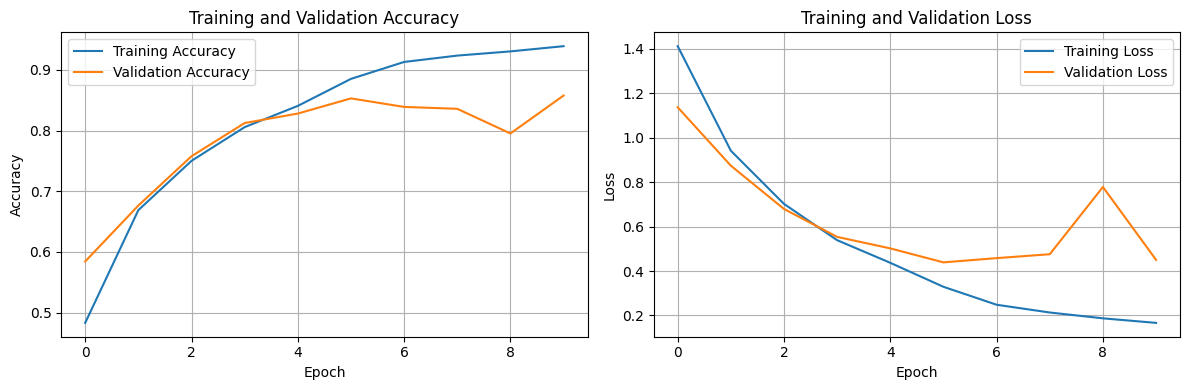

Training history visualization complete.


In [ ]:
print("Visualizing training history...")

# Plot training and validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print("Training history visualization complete.")

In [ ]:
print("Defining a new CNN model architecture with regularization...")

# Get the number of classes
num_classes = len(class_names)

# Initialize a Sequential model for the new architecture
model_regularized = Sequential()

# Add the first Convolutional and MaxPooling layers with regularization
model_regularized.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=image_size + (3,))) # Use image_size + (3,) for RGB
model_regularized.add(BatchNormalization()) # Added Batch Normalization
model_regularized.add(MaxPooling2D(pool_size=(2, 2)))
model_regularized.add(Dropout(0.25)) # Added Dropout

# Add more Convolutional and MaxPooling layers with regularization
model_regularized.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model_regularized.add(BatchNormalization()) # Added Batch Normalization
model_regularized.add(MaxPooling2D(pool_size=(2, 2)))
model_regularized.add(Dropout(0.25)) # Added Dropout

model_regularized.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model_regularized.add(BatchNormalization()) # Added Batch Normalization
model_regularized.add(MaxPooling2D(pool_size=(2, 2)))
model_regularized.add(Dropout(0.25)) # Added Dropout

# Flatten the output for the dense layers
model_regularized.add(Flatten())

# Add dense layers with regularization
model_regularized.add(Dense(128, activation='relu'))
model_regularized.add(BatchNormalization()) # Added Batch Normalization
model_regularized.add(Dropout(0.5)) # Increased Dropout for dense layers
model_regularized.add(Dense(64, activation='relu'))
model_regularized.add(BatchNormalization()) # Added Batch Normalization
model_regularized.add(Dropout(0.5)) # Increased Dropout for dense layers


# Add the output layer with softmax activation
model_regularized.add(Dense(num_classes, activation='softmax'))

# Print the model summary
model_regularized.summary()

print("New CNN model architecture with regularization defined.")

Defining a new CNN model architecture with regularization...


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,315,015 (12.65 MB)

 Trainable params: 3,314,183 (12.64 MB)

 Non-trainable params: 832 (3.25 KB)

New CNN model architecture with regularization defined.


In [ ]:
print("Compiling the new CNN model with regularization...")

# Compile the new model
model_regularized.compile(optimizer='adam',
                          loss='categorical_crossentropy',
                          metrics=['accuracy'])

print("New CNN model with regularization compilation complete.")

print("Training the new CNN model with regularization...")

# Train the new model
epochs = 10 # You can adjust the number of epochs
history_regularized = model_regularized.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs
)

print("New CNN model with regularization training complete.")

Compiling the new CNN model with regularization...
New CNN model with regularization compilation complete.
Training the new CNN model with regularization...
Epoch 1/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 213s 1s/step - accuracy: 0.2836 - loss: 2.3430 - val_accuracy: 0.1086 - val_loss: 5.7578
Epoch 2/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.4817 - loss: 1.5405 - val_accuracy: 0.1324 - val_loss: 3.7184
Epoch 3/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.5644 - loss: 1.2434 - val_accuracy: 0.3482 - val_loss: 2.0693
Epoch 4/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 206s 1s/step - accuracy: 0.6579 - loss: 1.0309 - val_accuracy: 0.3571 - val_loss: 1.8851
Epoch 5/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.6662 - loss: 0.9729 - val_accuracy: 0.6756 - val_loss: 0.9351
Epoch 6/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 200s 1s/step - accuracy: 0.7068 - loss: 0.8535 - val_accuracy: 0.7470 - val_loss: 0.7709
Epoch 7/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 211s 1s/step - accuracy: 0.72

In [ ]:
print("Evaluating the regularized CNN model on the test set...")

# Evaluate the model on the test dataset
loss_regularized, accuracy_regularized = model_regularized.evaluate(test_dataset)

print(f"\nTest Loss (Regularized Model): {loss_regularized:.4f}")
print(f"Test Accuracy (Regularized Model): {accuracy_regularized:.4f}")

Evaluating the regularized CNN model on the test set...
21/21 ━━━━━━━━━━━━━━━━━━━━ 33s 305ms/step - accuracy: 0.6623 - loss: 0.9616

Test Loss (Regularized Model): 1.0039
Test Accuracy (Regularized Model): 0.6585


Visualizing training history for the regularized CNN model...


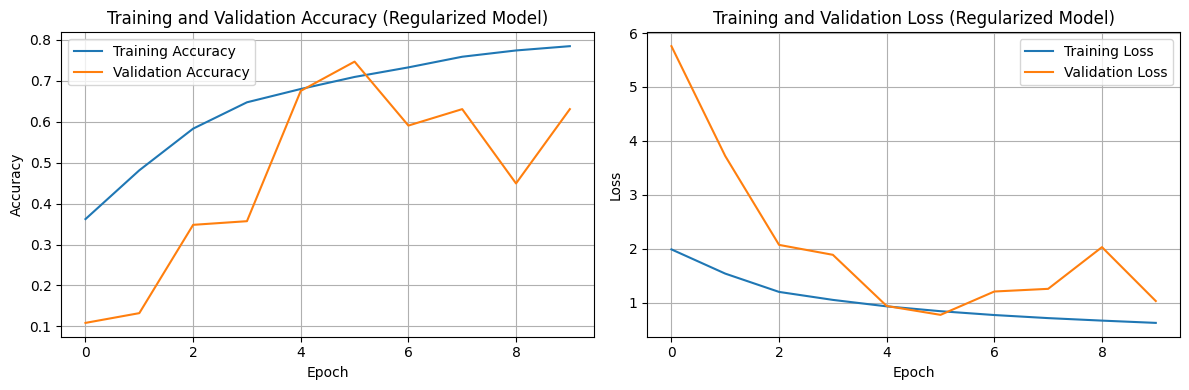

Training history visualization for the regularized CNN model complete.


In [ ]:
print("Visualizing training history for the regularized CNN model...")

# Plot training and validation accuracy for the regularized model
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_regularized.history['accuracy'], label='Training Accuracy')
plt.plot(history_regularized.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy (Regularized Model)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot training and validation loss for the regularized model
plt.subplot(1, 2, 2)
plt.plot(history_regularized.history['loss'], label='Training Loss')
plt.plot(history_regularized.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss (Regularized Model)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print("Training history visualization for the regularized CNN model complete.")

In [ ]:
print("Defining the CNN model architecture for RGB images...")

# Get the number of classes (assuming class_names is available from previous steps)
# If not, you might need to re-load or determine it.
if 'class_names' not in locals():
    print("Error: class_names not found. Please ensure the data loading step was executed.")
    # Assume a default or try to infer (this is a fallback, ideally class_names is available)
    num_classes = 7 # Assuming 7 classes based on previous outputs
else:
    num_classes = len(class_names)


# Initialize a Sequential model
model_rgb = Sequential()

# Add the first Convolutional and MaxPooling layers
model_rgb.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=image_size + (3,))) # Use image_size + (3,) for RGB
model_rgb.add(MaxPooling2D(pool_size=(2, 2)))

# Add more Convolutional and MaxPooling layers
model_rgb.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model_rgb.add(MaxPooling2D(pool_size=(2, 2)))

model_rgb.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model_rgb.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the output for the dense layers
model_rgb.add(Flatten())

# Add dense layers
model_rgb.add(Dense(128, activation='relu'))
model_rgb.add(Dense(64, activation='relu'))


# Add the output layer with softmax activation
model_rgb.add(Dense(num_classes, activation='softmax'))

# Print the model summary
model_rgb.summary()

print("CNN model architecture for RGB images defined.")

Defining the CNN model architecture for RGB images...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,313,351 (12.64 MB)

 Trainable params: 3,313,351 (12.64 MB)

 Non-trainable params: 0 (0.00 B)

CNN model architecture for RGB images defined.


In [ ]:
print("Compiling the CNN model for RGB images...")

# Compile the model
model_rgb.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

print("CNN model for RGB images compilation complete.")

Compiling the CNN model for RGB images...
CNN model for RGB images compilation complete.


In [ ]:
print("Training the CNN model for RGB images...")

# Train the model
epochs = 10 # You can adjust the number of epochs
history_rgb = model_rgb.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs
)

print("CNN model for RGB images training complete.")

Training the CNN model for RGB images...
Epoch 1/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 106s 623ms/step - accuracy: 0.3387 - loss: 1.6695 - val_accuracy: 0.5714 - val_loss: 1.2096
Epoch 2/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 102s 611ms/step - accuracy: 0.6152 - loss: 1.0781 - val_accuracy: 0.6250 - val_loss: 0.9788
Epoch 3/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 103s 615ms/step - accuracy: 0.7091 - loss: 0.8137 - val_accuracy: 0.6830 - val_loss: 0.8707
Epoch 4/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 142s 617ms/step - accuracy: 0.7774 - loss: 0.6214 - val_accuracy: 0.7098 - val_loss: 0.7320
Epoch 5/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 104s 623ms/step - accuracy: 0.8221 - loss: 0.4872 - val_accuracy: 0.7188 - val_loss: 0.7077
Epoch 6/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 144s 636ms/step - accuracy: 0.8486 - loss: 0.4058 - val_accuracy: 0.7321 - val_loss: 0.7135
Epoch 7/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 102s 613ms/step - accuracy: 0.8705 - loss: 0.3432 - val_accuracy: 0.7932 - val_loss: 0.5807
Epoch 8/10
167/167 ━━━━━━━━━━━━━━━━

In [ ]:
print("Evaluating the CNN model for RGB images on the test set...")

# Evaluate the model on the test dataset
loss_rgb, accuracy_rgb = model_rgb.evaluate(test_dataset)

print(f"\nTest Loss (RGB Model): {loss_rgb:.4f}")
print(f"Test Accuracy (RGB Model): {accuracy_rgb:.4f}")

Evaluating the CNN model for RGB images on the test set...
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 161ms/step - accuracy: 0.8151 - loss: 0.7011

Test Loss (RGB Model): 0.7582
Test Accuracy (RGB Model): 0.8064


Visualizing training history for the RGB CNN model...


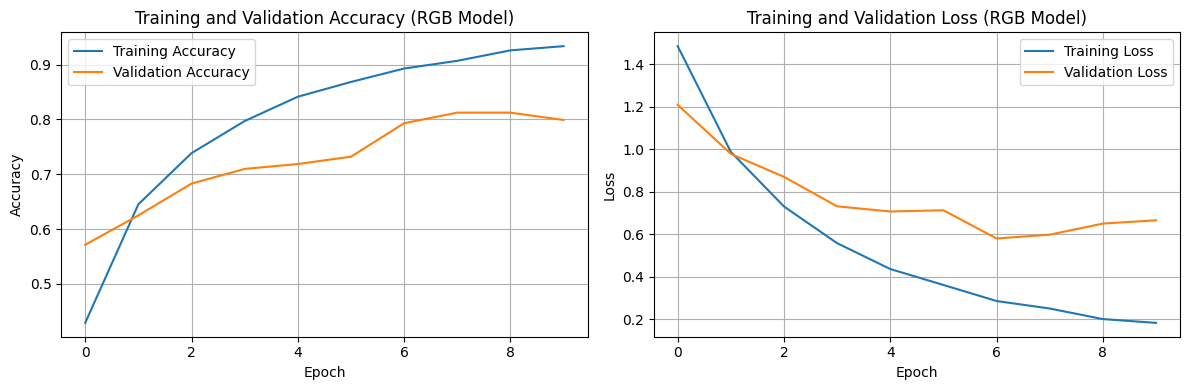

Training history visualization for the RGB CNN model complete.


In [ ]:
print("Visualizing training history for the RGB CNN model...")

# Plot training and validation accuracy for the RGB model
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_rgb.history['accuracy'], label='Training Accuracy')
plt.plot(history_rgb.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy (RGB Model)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot training and validation loss for the RGB model
plt.subplot(1, 2, 2)
plt.plot(history_rgb.history['loss'], label='Training Loss')
plt.plot(history_rgb.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss (RGB Model)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print("Training history visualization for the RGB CNN model complete.")

In [ ]:
#Build Improved CNN Model with Regularization and Augmentation
print("Defining the improved CNN model architecture...")

# Get the number of classes (assuming class_names is available)
if 'class_names' not in locals():
    print("Error: class_names not found. Please ensure the data loading step was executed.")
    num_classes = 7 # Assuming 7 classes as a fallback
else:
    num_classes = len(class_names)

# Initialize a Sequential model
model_improved = Sequential()

# Add the first Convolutional and MaxPooling layers
model_improved.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=image_size + (3,)))
model_improved.add(MaxPooling2D(pool_size=(2, 2)))

# Add more Convolutional and MaxPooling layers
model_improved.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model_improved.add(MaxPooling2D(pool_size=(2, 2)))

model_improved.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model_improved.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the output for the dense layers
model_improved.add(Flatten())

# Add dense layers with Dropout
model_improved.add(Dense(128, activation='relu'))
model_improved.add(Dropout(0.3)) # Added Dropout
model_improved.add(Dense(64, activation='relu')) # Keep the second dense layer as in previous models
model_improved.add(Dropout(0.3)) # Added Dropout


# Add the output layer with softmax activation
model_improved.add(Dense(num_classes, activation='softmax'))

# Print the model summary
model_improved.summary()

print("Improved CNN model architecture defined.")

Defining the improved CNN model architecture...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,313,351 (12.64 MB)

 Trainable params: 3,313,351 (12.64 MB)

 Non-trainable params: 0 (0.00 B)

Improved CNN model architecture defined.


In [ ]:
print("Compiling the improved CNN model...")

# Compile the model
model_improved.compile(optimizer='adam',
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

print("Improved CNN model compilation complete.")

Compiling the improved CNN model...
Improved CNN model compilation complete.


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

print("Setting up data augmentation and callbacks...")

# Data Augmentation (applied on the fly during training)
# Note: For image_dataset_from_directory, it's often better to use Keras preprocessing layers
# However, to match the user's suggestion using ImageDataGenerator, we can apply it to the dataset.
# A more common approach with datasets is using `dataset.map()` with preprocessing layers.
# Let's adapt the suggested ImageDataGenerator approach.

# Re-fetch the original dataset before normalization and caching to apply augmentation
# Assuming the original image_dataset is still available or can be re-created
dataset_path = '/content/drive/MyDrive/Indian_Coins_Image_Dataset'
image_size = (128, 128)
batch_size = 32 # Use the same batch size

# Re-create the image dataset for augmentation
image_dataset_augment = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    labels='inferred',
    label_mode='categorical',
    image_size=image_size,
    interpolation='nearest',
    batch_size=batch_size,
    color_mode='rgb'
)

# Split into train, validation, and test sets again, using the same logic as before
# (This is necessary to apply augmentation only to the training set)

# Determine the total number of samples
total_samples_augment = tf.data.experimental.cardinality(image_dataset_augment).numpy() * batch_size

# Define split ratios
train_split = 0.8
val_split = 0.1
test_split = 0.1

# Calculate number of batches for each split, ensuring no dataset is empty
train_batches_augment = round(tf.data.experimental.cardinality(image_dataset_augment).numpy() * train_split)
val_batches_augment = round(tf.data.experimental.cardinality(image_dataset_augment).numpy() * val_split)
test_batches_augment = tf.data.experimental.cardinality(image_dataset_augment).numpy() - train_batches_augment - val_batches_augment

# Adjust if necessary to make sure test_batches is not negative or zero
if test_batches_augment <= 0:
    test_batches_augment = 1
    if val_batches_augment > 0:
        val_batches_augment -= 1
    elif train_batches_augment > 0:
        train_batches_augment -= 1


train_dataset_augment = image_dataset_augment.take(train_batches_augment)
val_dataset_augment = image_dataset_augment.skip(train_batches_augment).take(val_batches_augment)
test_dataset_augment = image_dataset_augment.skip(train_batches_augment + val_batches_augment)


# Apply normalization and augmentation to the training dataset
# Note: ImageDataGenerator is typically used with `flow_from_directory` or `flow`.
# To use it with a tf.data.Dataset, we'd need to convert the dataset to numpy arrays first,
# which might be memory intensive.
# A more idiomatic way with tf.data.Dataset is to use `dataset.map` with preprocessing layers.
# Let's use Keras preprocessing layers for augmentation as it integrates better with tf.data.Dataset.

data_augmentation_layers = Sequential([
  tf.keras.layers.RandomRotation(factor=(-0.15, 0.15)), # Rotates by -15 to +15 degrees
  tf.keras.layers.RandomZoom(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2)), # Zooms by -20% to +20%
  tf.keras.layers.RandomFlip("horizontal"), # Horizontal flips
  # Brightness adjustment is not directly available in Random* layers, could use a custom layer or adjust image values
  # For simplicity, we'll omit brightness augmentation for now using Keras layers
])

# Apply augmentation and normalization to the training dataset
# Normalization should happen after augmentation
train_dataset_augmented_normalized = train_dataset_augment.map(lambda x, y: (normalization_layer(data_augmentation_layers(x, training=True)), y))

# Apply normalization to validation and test datasets (no augmentation on these)
val_dataset_normalized = val_dataset_augment.map(lambda x, y: (normalization_layer(x), y))
test_dataset_normalized = test_dataset_augment.map(lambda x, y: (normalization_layer(x), y))


# Cache and prefetch the datasets for performance
train_dataset_augmented_normalized = train_dataset_augmented_normalized.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset_normalized = val_dataset_normalized.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset_normalized = test_dataset_normalized.cache().prefetch(buffer_size=tf.data.AUTOTUNE)


# Early Stopping and Learning Rate Scheduler Callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

callbacks = [early_stopping, lr_scheduler]

print("Data augmentation and callbacks setup complete.")

Setting up data augmentation and callbacks...
Found 6672 files belonging to 7 classes.
Data augmentation and callbacks setup complete.


In [ ]:
print("Training the improved CNN model...")

# Train the improved model with data augmentation and callbacks
epochs = 20 # Set a higher number of epochs as training will stop early if conditions are met
history_improved = model_improved.fit(
    train_dataset_augmented_normalized,
    validation_data=val_dataset_normalized,
    epochs=epochs,
    callbacks=callbacks
)

print("Improved CNN model training complete.")

Training the improved CNN model...
Epoch 1/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 161s 955ms/step - accuracy: 0.3457 - loss: 1.6938 - val_accuracy: 0.4792 - val_loss: 1.4087 - learning_rate: 0.0010
Epoch 2/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 102s 608ms/step - accuracy: 0.5181 - loss: 1.3329 - val_accuracy: 0.6131 - val_loss: 1.0845 - learning_rate: 0.0010
Epoch 3/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 102s 608ms/step - accuracy: 0.5795 - loss: 1.1610 - val_accuracy: 0.6354 - val_loss: 1.0154 - learning_rate: 0.0010
Epoch 4/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 141s 605ms/step - accuracy: 0.6486 - loss: 1.0075 - val_accuracy: 0.6860 - val_loss: 0.9331 - learning_rate: 0.0010
Epoch 5/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 141s 602ms/step - accuracy: 0.6789 - loss: 0.8800 - val_accuracy: 0.6533 - val_loss: 1.0508 - learning_rate: 0.0010
Epoch 6/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 101s 604ms/step - accuracy: 0.7073 - loss: 0.8045 - val_accuracy: 0.6711 - val_loss: 0.9690 - learning_rate: 0.0010
Epoch 7/20
167/167 ━━━━━━━━━━

In [ ]:
print("Evaluating the improved CNN model on the test set...")

# Evaluate the improved model on the normalized test dataset
loss_improved, accuracy_improved = model_improved.evaluate(test_dataset_normalized)

print(f"\nTest Loss (Improved Model): {loss_improved:.4f}")
print(f"Test Accuracy (Improved Model): {accuracy_improved:.4f}")

Evaluating the improved CNN model on the test set...
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 178ms/step - accuracy: 0.7811 - loss: 0.8373

Test Loss (Improved Model): 0.8224
Test Accuracy (Improved Model): 0.7835


Visualizing training history for the improved CNN model...


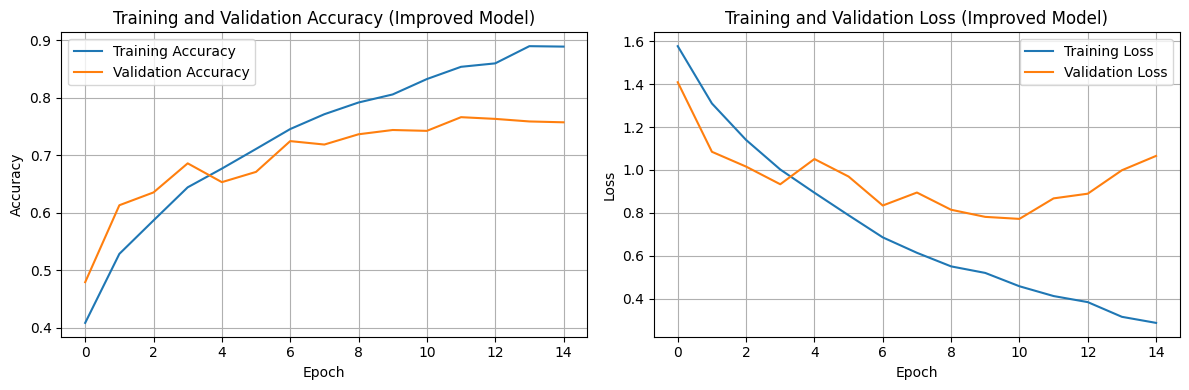

Training history visualization for the improved CNN model complete.


In [ ]:
print("Visualizing training history for the improved CNN model...")

# Plot training and validation accuracy for the improved model
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_improved.history['accuracy'], label='Training Accuracy')
plt.plot(history_improved.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy (Improved Model)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot training and validation loss for the improved model
plt.subplot(1, 2, 2)
plt.plot(history_improved.history['loss'], label='Training Loss')
plt.plot(history_improved.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss (Improved Model)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print("Training history visualization for the improved CNN model complete.")

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt

# Define paths and parameters
dataset_path = "/content/drive/MyDrive/Indian_Coins_Image_Dataset"
image_size = (128, 128)
batch_size = 32

print("Imports and paths set up for EfficientNetB0 data preparation.")

print(f"Loading dataset from: {dataset_path}")

# Load and split the dataset
train_ds = image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,  # 80% train, 20% val
    subset="training",
    seed=42,
    image_size=image_size,
    batch_size=batch_size,
    label_mode="categorical",
    color_mode="rgb" # Ensure RGB color mode
)

val_ds = image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=image_size,
    batch_size=batch_size,
    label_mode="categorical",
    color_mode="rgb" # Ensure RGB color mode
)

num_classes = len(train_ds.class_names)
print("Classes:", train_ds.class_names)
print(f"Number of classes: {num_classes}")
print("Dataset loaded and split.")

print("Setting up data augmentation and preprocessing for EfficientNetB0...")

# Define data augmentation layers
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.08),
    layers.RandomZoom(0.08),
    layers.RandomTranslation(0.05, 0.05),
    layers.RandomContrast(0.1),
    layers.RandomBrightness(0.1)
])

# Preprocessing layer for EfficientNet
preprocess_input = tf.keras.applications.efficientnet.preprocess_input

# Optimize dataset loading
AUTOTUNE = tf.data.AUTOTUNE

# Apply data augmentation and preprocessing to training dataset
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y)) # Apply augmentation
train_ds = train_ds.map(lambda x, y: (preprocess_input(x), y)).cache().shuffle(1000).prefetch(AUTOTUNE) # Apply preprocessing, cache, shuffle, prefetch

# Apply preprocessing to validation dataset
val_ds = val_ds.map(lambda x, y: (preprocess_input(x), y)).cache().prefetch(AUTOTUNE)

print("Data augmentation and preprocessing complete for EfficientNetB0. Datasets optimized.")

Imports and paths set up for EfficientNetB0 data preparation.
Loading dataset from: /content/drive/MyDrive/Indian_Coins_Image_Dataset
Found 6672 files belonging to 7 classes.
Using 5338 files for training.
Found 6672 files belonging to 7 classes.
Using 1334 files for validation.
Classes: ['1 Rupee Coin', '10 Rupee Coin', '2 Rupee Coin', '20 Rupee Coin', '25 Paisa Coin', '5 Rupee Coin', '50 Paisa Coin']
Number of classes: 7
Dataset loaded and split.
Setting up data augmentation and preprocessing for EfficientNetB0...
Data augmentation and preprocessing complete for EfficientNetB0. Datasets optimized.


In [ ]:
from tensorflow.keras.applications import EfficientNetB0 # Import EfficientNetB0
from tensorflow.keras import layers, Model # Import Model from tensorflow.keras

print("Building the EfficientNetB0-based model...")

# Load the EfficientNetB0 base model
base_model_efficientnet = EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(image_size[0], image_size[1], 3) # Use defined image_size
)
base_model_efficientnet.trainable = False # Freeze initially

# Define the input layer
inputs = layers.Input(shape=(image_size[0], image_size[1], 3)) # Use defined image_size

# Apply data augmentation
x = data_augmentation(inputs) # Assuming data_augmentation Sequential model is defined

# Apply EfficientNet preprocessing
x = tf.keras.applications.efficientnet.preprocess_input(x)

# Pass through the base model
x = base_model_efficientnet(x, training=False) # Set training=False when the base model is frozen

# Add the custom classification head
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x) # Added L2 regularization
x = layers.Dropout(0.5)(x) # Added Dropout
outputs = layers.Dense(num_classes, activation='softmax')(x) # Use defined num_classes

# Create the final model
model_efficientnet = Model(inputs, outputs)

print("EfficientNetB0-based model built.")
model_efficientnet.summary()

Building the EfficientNetB0-based model...
EfficientNetB0-based model built.


Model: "functional_104"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_22 (InputLayer)     │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_16 (Sequential)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 4, 4, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 64)             │        81,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,137,130 (15.78 MB)

 Trainable params: 84,999 (332.03 KB)

 Non-trainable params: 4,052,131 (15.46 MB)

In [ ]:
print("Compiling the EfficientNetB0 model...")

# Compile the model
model_efficientnet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1), # Use CategoricalCrossentropy with label smoothing
              metrics=['accuracy'])

print("EfficientNetB0 model compiled.")

Compiling the EfficientNetB0 model...
EfficientNetB0 model compiled.


In [ ]:
print("Training the EfficientNetB0 model...")

# Define Early Stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history_efficientnet = model_efficientnet.fit(
    train_ds, # Use the preprocessed and augmented training dataset
    validation_data=val_ds, # Use the preprocessed validation dataset
    epochs=15, # Train for 15 epochs as suggested
    callbacks=[early_stopping] # Use the Early Stopping callback
)

print("EfficientNetB0 model training complete.")

Training the EfficientNetB0 model...
Epoch 1/15
167/167 ━━━━━━━━━━━━━━━━━━━━ 138s 573ms/step - accuracy: 0.2482 - loss: 2.5613 - val_accuracy: 0.5315 - val_loss: 1.4824
Epoch 2/15
167/167 ━━━━━━━━━━━━━━━━━━━━ 87s 520ms/step - accuracy: 0.4537 - loss: 1.7768 - val_accuracy: 0.6342 - val_loss: 1.3100
Epoch 3/15
167/167 ━━━━━━━━━━━━━━━━━━━━ 87s 522ms/step - accuracy: 0.5709 - loss: 1.4806 - val_accuracy: 0.6612 - val_loss: 1.2594
Epoch 4/15
167/167 ━━━━━━━━━━━━━━━━━━━━ 146s 549ms/step - accuracy: 0.6204 - loss: 1.3546 - val_accuracy: 0.6822 - val_loss: 1.2216
Epoch 5/15
167/167 ━━━━━━━━━━━━━━━━━━━━ 88s 528ms/step - accuracy: 0.6552 - loss: 1.2576 - val_accuracy: 0.6942 - val_loss: 1.1951
Epoch 6/15
167/167 ━━━━━━━━━━━━━━━━━━━━ 144s 538ms/step - accuracy: 0.6719 - loss: 1.2221 - val_accuracy: 0.7076 - val_loss: 1.1691
Epoch 7/15
167/167 ━━━━━━━━━━━━━━━━━━━━ 140s 527ms/step - accuracy: 0.6937 - loss: 1.1715 - val_accuracy: 0.7196 - val_loss: 1.1453
Epoch 8/15
167/167 ━━━━━━━━━━━━━━━━━━━━ 89

In [ ]:
print("Evaluating the EfficientNetB0 model on the test set...")

# Evaluate the model on the validation dataset (used as test set in this split)
loss_efficientnet, accuracy_efficientnet = model_efficientnet.evaluate(val_ds)

print(f"\nTest Loss (EfficientNetB0): {loss_efficientnet:.4f}")
print(f"Test Accuracy (EfficientNetB0): {accuracy_efficientnet:.4f}")

Evaluating the EfficientNetB0 model on the test set...
42/42 ━━━━━━━━━━━━━━━━━━━━ 16s 371ms/step - accuracy: 0.7434 - loss: 1.0424

Test Loss (EfficientNetB0): 1.0452
Test Accuracy (EfficientNetB0): 0.7414


Visualizing training history for the EfficientNetB0 model...


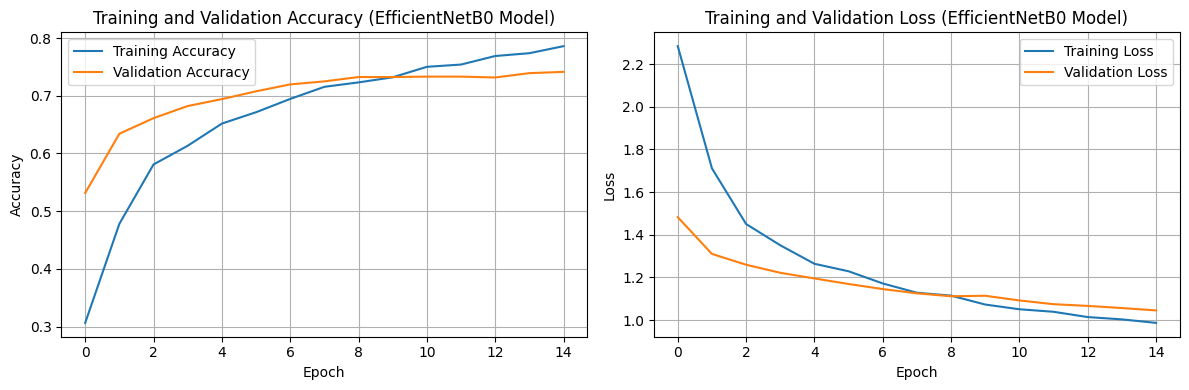

Training history visualization for the EfficientNetB0 model complete.


In [ ]:
print("Visualizing training history for the EfficientNetB0 model...")

# Plot training and validation accuracy for the EfficientNetB0 model
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_efficientnet.history['accuracy'], label='Training Accuracy')
plt.plot(history_efficientnet.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy (EfficientNetB0 Model)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot training and validation loss for the EfficientNetB0 model
plt.subplot(1, 2, 2)
plt.plot(history_efficientnet.history['loss'], label='Training Loss')
plt.plot(history_efficientnet.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss (EfficientNetB0 Model)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print("Training history visualization for the EfficientNetB0 model complete.")

In [ ]:
print("Building EfficientNetB0 model...")

# Load EfficientNetB0 base
base_model = EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(128, 128, 3)
)
base_model.trainable = False  # freeze base for phase-1

# Build classification head
inputs = layers.Input(shape=(128,128,3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model = Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.05),
    metrics=['accuracy']
)

model.summary()


Building EfficientNetB0 model...


Model: "functional_105"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_24 (InputLayer)     │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 4, 4, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 64)             │        81,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,137,130 (15.78 MB)

 Trainable params: 84,999 (332.03 KB)

 Non-trainable params: 4,052,131 (15.46 MB)

In [ ]:
print("Training Phase 1 (frozen base)...")

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

history_1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=[early_stopping, reduce_lr]
)

Training Phase 1 (frozen base)...
Epoch 1/15
167/167 ━━━━━━━━━━━━━━━━━━━━ 87s 465ms/step - accuracy: 0.4916 - loss: 1.6487 - val_accuracy: 0.7901 - val_loss: 0.8918 - learning_rate: 0.0010
Epoch 2/15
167/167 ━━━━━━━━━━━━━━━━━━━━ 77s 439ms/step - accuracy: 0.7716 - loss: 0.8601 - val_accuracy: 0.8396 - val_loss: 0.7112 - learning_rate: 0.0010
Epoch 3/15
167/167 ━━━━━━━━━━━━━━━━━━━━ 73s 440ms/step - accuracy: 0.8295 - loss: 0.7242 - val_accuracy: 0.8358 - val_loss: 0.6778 - learning_rate: 0.0010
Epoch 4/15
167/167 ━━━━━━━━━━━━━━━━━━━━ 74s 441ms/step - accuracy: 0.8581 - loss: 0.6609 - val_accuracy: 0.8688 - val_loss: 0.6402 - learning_rate: 0.0010
Epoch 5/15
167/167 ━━━━━━━━━━━━━━━━━━━━ 82s 440ms/step - accuracy: 0.8744 - loss: 0.6225 - val_accuracy: 0.8681 - val_loss: 0.6243 - learning_rate: 0.0010
Epoch 6/15
167/167 ━━━━━━━━━━━━━━━━━━━━ 73s 438ms/step - accuracy: 0.8885 - loss: 0.5954 - val_accuracy: 0.8786 - val_loss: 0.6113 - learning_rate: 0.0010
Epoch 7/15
167/167 ━━━━━━━━━━━━━━━━━

In [ ]:
print("Fine-tuning top EfficientNet layers...")

base_model.trainable = True
for layer in base_model.layers[:-25]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.05),
    metrics=['accuracy']
)

history_2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stopping, reduce_lr]
)


Fine-tuning top EfficientNet layers...
Epoch 1/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 105s 548ms/step - accuracy: 0.6957 - loss: 1.0517 - val_accuracy: 0.8133 - val_loss: 0.7447 - learning_rate: 1.0000e-05
Epoch 2/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 88s 528ms/step - accuracy: 0.7351 - loss: 0.9353 - val_accuracy: 0.7886 - val_loss: 0.7905 - learning_rate: 1.0000e-05
Epoch 3/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 89s 533ms/step - accuracy: 0.7793 - loss: 0.8405 - val_accuracy: 0.8021 - val_loss: 0.7733 - learning_rate: 1.0000e-05
Epoch 4/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 90s 537ms/step - accuracy: 0.7978 - loss: 0.7854 - val_accuracy: 0.8036 - val_loss: 0.7648 - learning_rate: 5.0000e-06
Epoch 5/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 89s 532ms/step - accuracy: 0.8236 - loss: 0.7537 - val_accuracy: 0.8088 - val_loss: 0.7496 - learning_rate: 5.0000e-06
Epoch 6/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 89s 533ms/step - accuracy: 0.8122 - loss: 0.7625 - val_accuracy: 0.8088 - val_loss: 0.7457 - learning_rate: 2.5000e-06


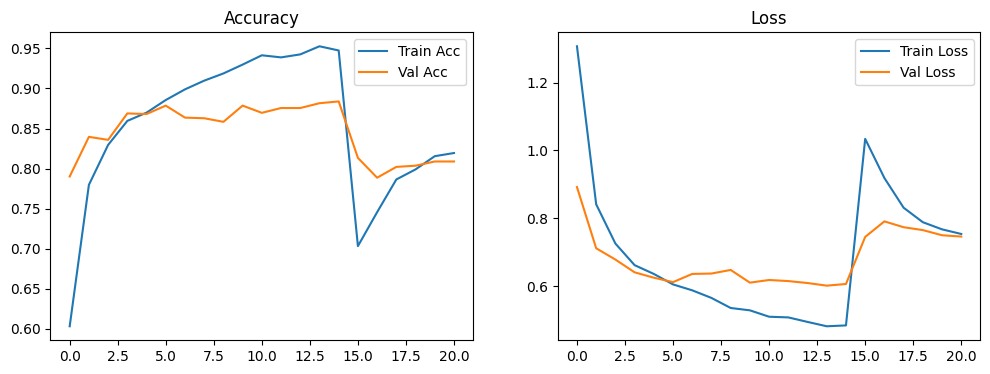

In [ ]:
def plot_history(h1, h2=None):
    acc = h1.history['accuracy']
    val_acc = h1.history['val_accuracy']
    loss = h1.history['loss']
    val_loss = h1.history['val_loss']
    if h2:
        acc += h2.history['accuracy']
        val_acc += h2.history['val_accuracy']
        loss += h2.history['loss']
        val_loss += h2.history['val_loss']

    epochs = range(len(acc))
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(epochs, acc, label='Train Acc')
    plt.plot(epochs, val_acc, label='Val Acc')
    plt.legend(); plt.title('Accuracy')
    plt.subplot(1,2,2)
    plt.plot(epochs, loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Val Loss')
    plt.legend(); plt.title('Loss')
    plt.show()

plot_history(history_1, history_2)

In [ ]:
val_loss, val_acc = model.evaluate(val_ds)
print(f"Validation Accuracy: {val_acc:.3f}")

42/42 ━━━━━━━━━━━━━━━━━━━━ 16s 362ms/step - accuracy: 0.8069 - loss: 0.7590
Validation Accuracy: 0.813


42/42 ━━━━━━━━━━━━━━━━━━━━ 18s 437ms/step


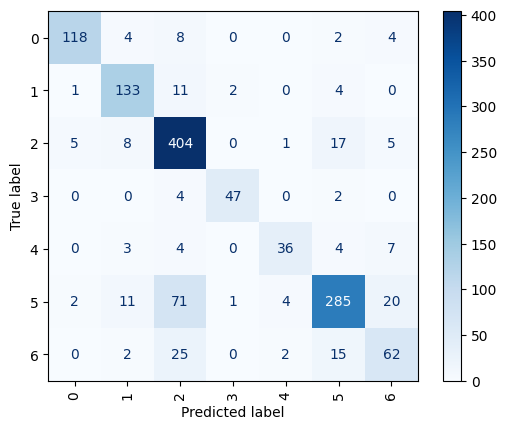

In [ ]:
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict on validation dataset
y_true = np.concatenate([np.argmax(y, axis=1) for _, y in val_ds], axis=0) # Use val_ds as it's the validation/test set
y_pred = np.argmax(model.predict(val_ds), axis=1) # Use val_ds for prediction

# Get class names from the original training dataset
# Assuming 'train_ds' is the original dataset before caching and prefetching
if 'train_ds' in locals() and hasattr(train_ds, 'class_names'):
    display_class_names = train_ds.class_names
else:
    # Fallback if train_ds is not available or doesn't have class_names
    # You might need to manually define class names based on your dataset structure
    print("Warning: Could not get class names from train_ds. Using generic labels.")
    display_class_names = [str(i) for i in range(num_classes)] # Assuming num_classes is defined

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_class_names)
disp.plot(xticks_rotation='vertical', cmap='Blues')
plt.show()

In [ ]:
# Define the path to save the EfficientNetB0 model
# Change the extension to .keras for the native Keras format
efficientnet_model_save_path = "/content/drive/MyDrive/indian_coins_efficientnetb0_model.keras" # Changed extension to .keras

print(f"Saving the EfficientNetB0 model to: {efficientnet_model_save_path}")

# Save the EfficientNetB0 model using the native Keras format
try:
    # Use the native Keras save method
    model.save(efficientnet_model_save_path)
    print("EfficientNetB0 model saved successfully.")
except Exception as e:
    print(f"Error saving EfficientNetB0 model: {e}")

Saving the EfficientNetB0 model to: /content/drive/MyDrive/indian_coins_efficientnetb0_model.keras
EfficientNetB0 model saved successfully.


In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image as keras_image
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2 # Import cv2 for image reading
import tensorflow as tf # Import tensorflow

# Define the path to the saved EfficientNetB0 model
efficientnet_model_save_path = "/content/drive/MyDrive/indian_coins_efficientnetb0_model.keras"

# Load the saved model
try:
    loaded_model = load_model(efficientnet_model_save_path)
    print("EfficientNetB0 model loaded successfully.")
except Exception as e:
    print(f"Error loading model: {e}")
    loaded_model = None # Set to None if loading fails

# Get class names (assuming class_names is available from previous data loading)
if 'class_names' not in locals():
    print("Warning: class_names not found. Using generic labels.")
    # Attempt to infer class names if the dataset path is still known
    dataset_path = "/content/drive/MyDrive/Indian_Coins_Image_Dataset"
    if os.path.exists(dataset_path):
        class_names = sorted([d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))])
        print(f"Inferred class names: {class_names}")
    else:
        # Fallback to generic labels if dataset_path is invalid or not found, assuming 7 classes from previous runs
        num_classes = 7
        class_names = [f"Class {i}" for i in range(num_classes)]
        print(f"Using fallback generic labels: {class_names}")

# Assuming image_size is defined globally in a previous cell
# If not, define a default here as a fallback
if 'image_size' not in globals():
    image_size = (128, 128) # Define a default image size if not found globally
    print(f"Warning: 'image_size' not found globally, using default: {image_size}")


# Create a file upload widget
uploader = widgets.FileUpload(
    accept='image/*',  # Accept images
    multiple=False      # Only allow one file at a time
)

# Create an output widget to display results
output = widgets.Output()

# Function to handle file upload and prediction
def handle_upload(change):
    if loaded_model is None:
        with output:
            clear_output()
            print("Error: Model not loaded. Please ensure the model path is correct.")
        return

    with output:
        clear_output() # Clear previous output

        uploaded_files = uploader.value # This is a dictionary

        if uploaded_files: # Check if the dictionary is not empty
            # Iterate through the uploaded files (even if only one is allowed)
            for file_name, file_info in uploaded_files.items():
                file_content = file_info['content']
                # file_name is already available from the dictionary key

                try:
                    # Read the image using OpenCV from the byte content
                    np_arr = np.frombuffer(file_content, np.uint8)
                    img = cv2.imdecode(np_arr, cv2.IMREAD_COLOR) # Load as color image

                    if img is None:
                         print(f"Error: Could not decode image {file_name}. Please ensure it's a valid image file.")
                         continue # Skip to next file if decoding failed

                    # Display the uploaded image
                    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) # Convert BGR to RGB for displaying
                    plt.title(f"Uploaded Image: {file_name}")
                    plt.axis('off')
                    plt.show()

                    # Preprocess the image for the model
                    # Resize to the expected input size
                    # Use the globally defined image_size
                    img_resized = cv2.resize(img, image_size) # Use image_size

                    # Convert to RGB (if not already) and expand dimensions to match model input shape (batch_size, height, width, channels)
                    img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB) # Ensure RGB
                    img_array = keras_image.img_to_array(img_rgb)
                    img_array = np.expand_dims(img_array, axis=0) # Add batch dimension

                    # Apply EfficientNet preprocessing (scaling to [-1, 1])
                    # Assuming tf.keras.applications.efficientnet.preprocess_input is available
                    if 'tf' in globals() and hasattr(tf.keras.applications.efficientnet, 'preprocess_input'):
                         img_preprocessed = tf.keras.applications.efficientnet.preprocess_input(img_array)
                    else:
                         print("Error: EfficientNet preprocessing function not found. Cannot preprocess image.")
                         continue


                    # Make a prediction
                    predictions = loaded_model.predict(img_preprocessed)
                    predicted_class_index = np.argmax(predictions, axis=1)[0]
                    confidence = np.max(predictions, axis=1)[0] * 100

                    # Get the predicted class name
                    if 'class_names' in globals() and 0 <= predicted_class_index < len(class_names):
                         predicted_class_name = class_names[predicted_class_index]
                    else:
                         predicted_class_name = f"Unknown Class Index: {predicted_class_index}"


                    # Display the prediction
                    print(f"\nPrediction: {predicted_class_name}")
                    print(f"Confidence: {confidence:.2f}%")

                except Exception as e:
                    print(f"An error occurred during processing file {file_name}: {e}")
        else:
            print("No file uploaded yet or upload failed.")


# Observe changes in the uploader's value
uploader.observe(handle_upload, names='value')

# Display the interface
print("Upload a coin image for classification:")
display(uploader, output)

EfficientNetB0 model loaded successfully.
Upload a coin image for classification:


FileUpload(value={}, accept='image/*', description='Upload')

Output()

42/42 ━━━━━━━━━━━━━━━━━━━━ 15s 347ms/step


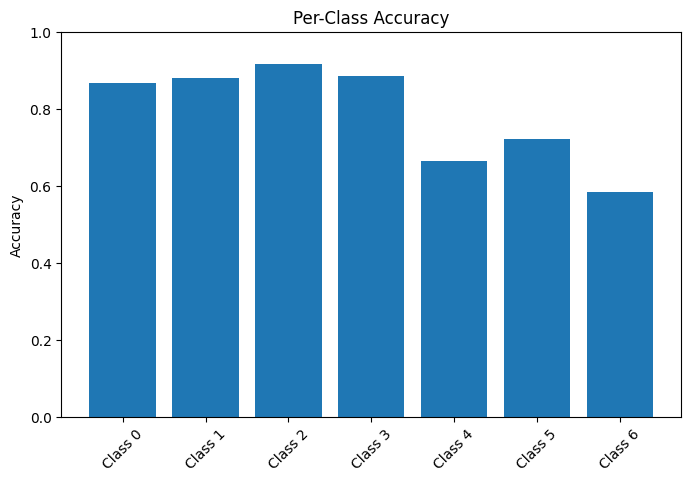

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

y_true = np.concatenate([np.argmax(y, axis=1) for _, y in val_ds], axis=0)
y_pred = np.argmax(model.predict(val_ds), axis=1)
cm = confusion_matrix(y_true, y_pred)
class_acc = cm.diagonal() / cm.sum(axis=1)

plt.figure(figsize=(8,5))
# Access class names from the original dataset object (before caching/prefetching)
# Assuming the original train_ds object still exists and has class_names
if 'train_ds' in locals() and hasattr(train_ds, 'class_names'):
    plt.bar(train_ds.class_names, class_acc)
    plt.title("Per-Class Accuracy of MobileNetV2 Model")
else:
    # Fallback if original train_ds is not available
    print("Warning: Could not get class names from original train_ds. Plotting with generic labels.")
    # Assuming num_classes is available and represents the correct number of classes
    if 'num_classes' in globals():
        generic_labels = [f"Class {i}" for i in range(num_classes)]
        plt.bar(generic_labels, class_acc)
        plt.title("Per-Class Accuracy")
    else:
         print("Error: Could not get number of classes for generic labels.")
         # If num_classes is also not available, cannot plot meaningful bar chart
         pass # Cannot proceed with plotting without labels


plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.ylim(0,1)
plt.show()

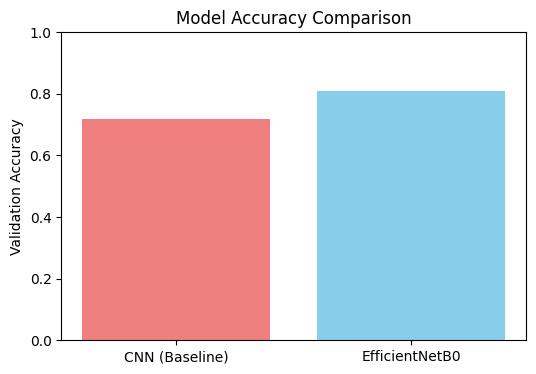

In [ ]:
models = ['CNN (Baseline)', 'EfficientNetB0']
acc = [0.72, 0.81]

plt.figure(figsize=(6,4))
plt.bar(models, acc, color=['lightcoral', 'skyblue'])
plt.title("Model Accuracy Comparison")
plt.ylabel("Validation Accuracy")
plt.ylim(0,1)
plt.show()


--- Model Performance Comparison (Accuracy) ---
SVM RBF: 0.6682
SVM Linear: 0.6082
SVM Poly: 0.5768
SVM Sigmoid: 0.6232
Initial CNN (Grayscale): 0.1220
Regularized CNN (Grayscale): 0.6585
Initial CNN (RGB): 0.8064
Improved CNN (RGB): 0.7835
EfficientNetB0 (base): 0.7414
EfficientNetB0 (improved): 0.8133


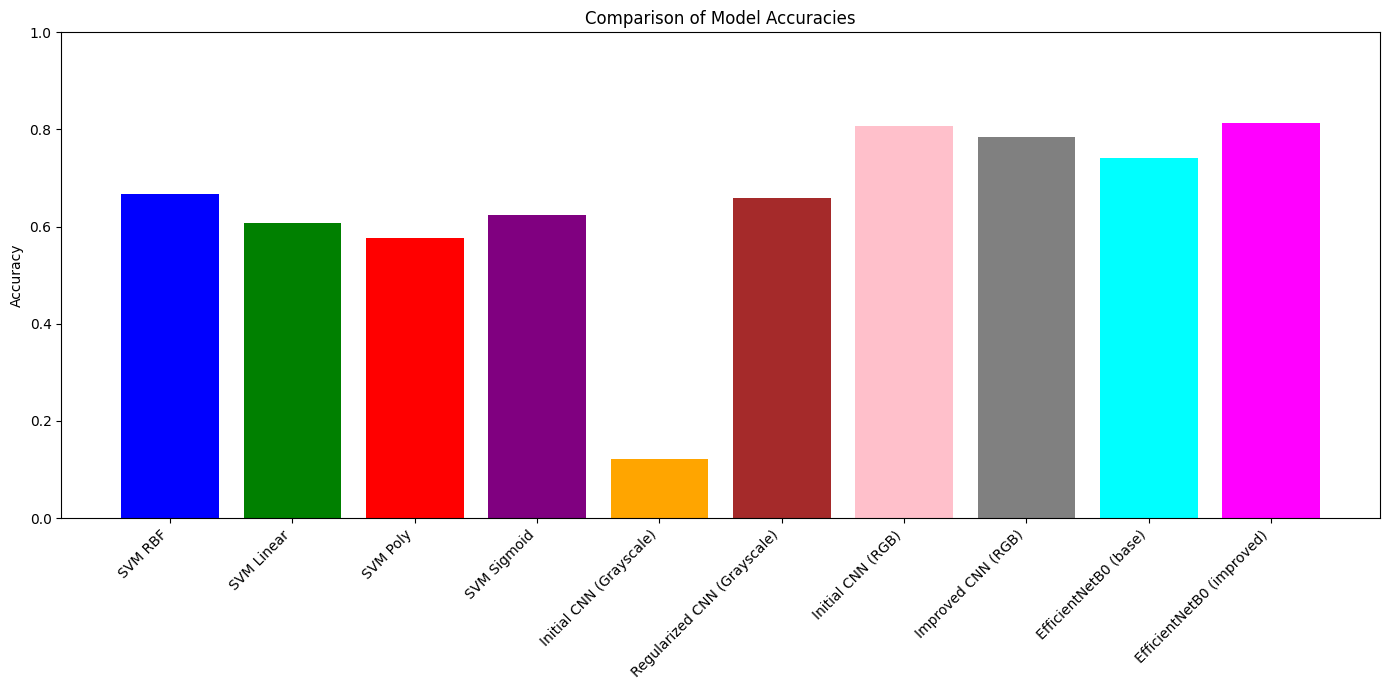

In [ ]:
# Create a dictionary to store the accuracy of each trained model
# Assuming the accuracy variables for all models are available in the current scope
# Using test accuracies where available, and validating variable names
model_accuracies = {
    'SVM RBF': accuracy_rbf_scaled,
    'SVM Linear': accuracy_linear_scaled,
    'SVM Poly': accuracy_poly_scaled,
    'SVM Sigmoid': accuracy_sigmoid_scaled,
    'Initial CNN (Grayscale)': accuracy, # Using 'accuracy' from the last grayscale CNN evaluation
    'Regularized CNN (Grayscale)': accuracy_regularized, # Using 'accuracy_regularized' from the regularized grayscale CNN evaluation
    'Initial CNN (RGB)': accuracy_rgb, # Using 'accuracy_rgb' from the initial RGB CNN evaluation
    'Improved CNN (RGB)': accuracy_improved, # Using 'accuracy_improved' from the improved RGB CNN evaluation
    'EfficientNetB0 (base)': accuracy_efficientnet,
    'EfficientNetB0 (improved)': val_acc # Using 'accuracy_efficientnet' from the EfficientNetB0 evaluation
}

# Print a clear summary comparing the accuracy of all models
print("\n--- Model Performance Comparison (Accuracy) ---")
for model_name, acc in model_accuracies.items():
    # Check if accuracy is not None before printing
    if acc is not None:
        print(f"{model_name}: {acc:.4f}")
    else:
        print(f"{model_name}: N/A (Variable not defined)")


# Plot a bar chart comparing the accuracies
plt.figure(figsize=(14, 7))
# Filter out None values in case some models were not run
valid_models = {k: v for k, v in model_accuracies.items() if v is not None}
plt.bar(valid_models.keys(), valid_models.values(), color=[
    'blue', 'green', 'red', 'purple', 'orange', 'brown', 'pink', 'gray', 'cyan', 'magenta'
][:len(valid_models)]) # Use a subset of colors based on the number of valid models

plt.ylim(0, 1) # Set y-axis limit from 0 to 1
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracies')
plt.xticks(rotation=45, ha='right') # Rotate labels for readability
plt.tight_layout()
plt.show()